# Проект 6: Выбираем авто выгодно.
## Работу выполнил: студент группы *DSPR-38*, *Светлаков Сергей*.
## Дата сдачи проекта: *23.04.2020*.

***Таким текстом отображаюстя промежуточные выводы для финальной версии программы и результатов на Kaggle.***

<span style='color:Red'> ***Таким текстом отображаются промежуточные выводы, соответствующие предыдущим версия программы. Также так отображаются выводы "между строк" автора работы.*** </span>

In [1]:
#Для работы с данными
import numpy as np
import pandas as pd
#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
#Для машинного обучения
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,\
                             BaggingRegressor,GradientBoostingRegressor,StackingRegressor
from catboost import CatBoostRegressor
#Сторонние модули
import sub_module.visualization as viz
import sub_module.ml as ml
import sub_module.data_processing as dp
import sub_module.after_parsing as ap
#Для работы с датой
from datetime import datetime
import time

In [2]:
#Для воспроизведения результатов
random_state = 42
#Для оформления графиков
sns.set()

***Выводы по работе содержит только данный notebook, остальные комментариев лишены. Все комментарии по прочим notebook'ам находятся тут.***

# 1. Чтение данных

***В первую очередь стоит понять, что обучающая выборка, как в предыдущих проектах, отсутствует, поэтому нужно собрать (напарсить) ее с дополнительных ресурсов самостоятельно. Для этого в описании к проекту на SkillFactory был приведен пример сайта auto.ru.***

## ***Комментарий к notebook "module-6-parsing_data_autoru":***

***Все данные собирались с сайта auto.ru, а именно со странички: auto.ru/moskva/cars/. Отметим несколько важных моментов:***

***1. Для любого запроса по данной ссылке выводятся объявления для МОСКВЫ и +200 км от МКАД. Этому соответствует приписка в адресе /moskva/. Тестовая выборка содержит объявления только для Москвы.***

***2. По одному запросу выводится максимум 37 объявлений на одной странице и максимум 99 страниц. То есть максимум для одного запроса можно получить 3633 объявлений. В данном случае цифра 3633 относится к типу запроса, когда не указан ни один фильтр.***

***3. Соответственно из вывода 2: необходимо вводить дополнительные фильтры, чтобы увеличить число запросов до n штук и тем самым увеличить размер обучающей выборки до n*3633.***

***4. Простым решением пункта 3 является метод деления запросов по бренду и модели машины. Пример такого запроса: auto.ru/moskva/cars/bmw/x5/. После привычного cars/ добавляется 'бренд'/ и 'модель'/.***

***5. Сразу же возникает вопрос: парсить ли все существующие бренды с сайта? С одной стороны да, это делает нашу выборку независимой от тестовой на Kaggle. C другой стороны это времязатраный процесс (парсинг 100к объявлений занимает ~24 ЧАСА), и количество объявлений, собранных для брендов и марок, имеющихся только в тестовой выборке, превышает 100к, что является достаточным для обучения модели и анализа данных.*** 

***Код модуля "module-6-parsing_data_autoru" разделен на следующие блоки: функции, чтение test, парсинг train, парсинг test, парсинг price & rating и парсинг train+test (дополнительно). Третий и четвертый блоки являются основными, по которым собираются тестовая и обучающая выборки. Блоки пять и шесть позволяют собрать дополнительную информацию для модели машины со страницы https://auto.ru/stats/cars/ и https://auto.ru/reviews/cars/, соответственно цену на модель, предсказанную auto.ru по объявлениям за последний месяц, и рейтинг модели на сайте.***

<span style='color:Red'> ***Седьмой блок появился в процессе решения проекта, когда я уже собрал все данные, но понял, что забыл вытащить еще один важный признак, а именно: дату объявления. К сожалению также хотелось бы вытащить еще дату производства машины, но библиотека lxml не позволила это сделать.*** </span>

<span style='color:Red'> ***Также стоит заметить, что на данный момент блок четыре (парсинг test) является неработающим, что связано со структурной переделкой кода, а именно блока функций, для парсинга train, когда test уже был успешно собран.*** </span>

***По моему мнению была собрана вся важная информация со странички объявления (за исключением текста описания) и оформлено в DataFrame по пути Data/train.csv. Прочие файлы: тестовая выборка Data/test.csv, данные мо моделям Data/price_auto_ru.csv (цена по auto.tu), Data/rating_auto_ru.csv (рейтинг по auto.ru), дополнительный столбец с признаком даты объявлений Data/date_data.csv и исходная выборка, представленная на Kaggle: Data/test_Kaggle.csv.***

<span style='color:Red'> ***Также стоит отметить, что объявления собирались не только по Москве, а по всей России. Чтобы увеличить число прецендентов.*** </span>

In [3]:
#Чтение
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')
df_test_old = pd.read_csv('Data/test_Kaggle.csv')
df_price = pd.read_csv('Data/price_auto_ru.csv')
df_rating = pd.read_csv('Data/rating_auto_ru.csv')
df_date = pd.read_csv('Data/date_data.csv')

In [4]:
#Пометка данных на тренировочные и тестовые
df_train['Kaggle'] = 0
df_test['Kaggle'] = 1
df_test['price'] = 0
#Объединение dataset'ов
df = pd.concat([df_train, df_test],ignore_index=True)
#Копирование
df_init = df.copy()

In [5]:
#Для вывода на Kaggle
sample_submissions = df_test_old[['sell_id','car_url']]

# 2. Доработка данных

***Так как все данные представлены после парсинга в виде, не подходящем для анализа данных и построения моделей, необходимо сделать первичные преобразования.***

## 2.1) date

<span style='color:Red'> ***В первую очередь вернем потерянный столбец в DataFrame.*** </span>

In [6]:
#Удаление столбца
df_date = df_date.drop(columns=['Unnamed: 0'])

In [7]:
#Разделение выборок
df_date_train = df_date.query('Kaggle==0').set_index('url')
df_date_test = df_date.query('Kaggle==1').set_index('url')
#Индексы обучающей и тестовой выборок
list_date_train = list(df_date_train.index)
list_date_test = list(df_date_test.index)

In [8]:
#Объединение
df.loc[df['Kaggle'] == 0,'date'] = df.query('Kaggle==0')['url'].\
                    apply(lambda x: df_date_train.loc[x]['xpath_date'] if x in list_date_train else np.nan)
df.loc[df['Kaggle'] == 1,'date'] = df.query('Kaggle==1')['url'].\
                    apply(lambda x: df_date_test.loc[x]['xpath_date'] if x in list_date_test else np.nan)

## 2.2) train&test

***Все данные приведены в типе string. Преобразуем каждый признак в надлежащий вид: int, float, list, object.***

In [9]:
#Осмотр данных
df.head(5)

Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             0   
2           2             0   
3           3             0   
4           4             0   

                                                 url                     year  \
0  https://auto.ru/cars/used/sale/skoda/octavia/1...  ['год выпуска', '2012']   
1  https://auto.ru/cars/used/sale/skoda/octavia/1...  ['год выпуска', '2009']   
2  https://auto.ru/cars/used/sale/skoda/octavia/1...  ['год выпуска', '2014']   
3  https://auto.ru/cars/used/sale/skoda/octavia/1...  ['год выпуска', '2014']   
4  https://auto.ru/cars/used/sale/skoda/octavia/1...  ['год выпуска', '2012']   

                          mileage             type_body  \
0  ['Пробег', '207\xa0000\xa0км']  ['Кузов', 'лифтбек']   
1  ['Пробег', '147\xa0000\xa0км']  ['Кузов', 'лифтбек']   
2  ['Пробег', '126\xa0000\xa0км']  ['Кузов', 'лифтбек']   
3  ['Пробег', '128\xa0000\xa0км']  ['Кузов', 'лифтбек']   
4  ['Пробег', '115\xa0000\xa0км']  ['Кузов', 'лифтбек']   

                     color                                        char_engine  \
0       ['Цвет', 'чёрный']  ['Двигатель', '1.4 л / 122\xa0л.с. / ', 'Бензин']   
1        ['Цвет', 'серый']  ['Двигатель', '1.6 л / 102\xa0л.с. / ', 'Бензин']   
2        ['Цвет', 'серый']  ['Двигатель', '1.6 л / 110\xa0л.с. / ', 'Бензин']   
3       ['Цвет', 'чёрный']  ['Двигатель', '1.4 л / 140\xa0л.с. / ', 'Бензин']   
4  ['Цвет', 'серебристый']  ['Двигатель', '1.6 л / 102\xa0л.с. / ', 'Бензи...   

                 type_transmission              type_drive         type_wheel  \
0  ['Коробка', 'роботизированная']  ['Привод', 'передний']  ['Руль', 'Левый']   
1      ['Коробка', 'механическая']  ['Привод', 'передний']  ['Руль', 'Левый']   
2    ['Коробка', 'автоматическая']  ['Привод', 'передний']  ['Руль', 'Левый']   
3  ['Коробка', 'роботизированная']  ['Привод', 'передний']  ['Руль', 'Левый']   
4      ['Коробка', 'механическая']  ['Привод', 'передний']  ['Руль', 'Левый']   

                                 state                     count_owners  \
0  ['Состояние', 'Не требует ремонта']     ['Владельцы', '3 или более']   
1  ['Состояние', 'Не требует ремонта']     ['Владельцы', '3 или более']   
2  ['Состояние', 'Не требует ремонта']   ['Владельцы', '1\xa0владелец']   
3  ['Состояние', 'Не требует ремонта']     ['Владельцы', '3 или более']   
4  ['Состояние', 'Не требует ремонта']  ['Владельцы', '2\xa0владельца']   

                   pts                    customs  \
0  ['ПТС', 'Дубликат']  ['Таможня', 'Растаможен']   
1  ['ПТС', 'Оригинал']  ['Таможня', 'Растаможен']   
2  ['ПТС', 'Оригинал']  ['Таможня', 'Растаможен']   
3  ['ПТС', 'Оригинал']  ['Таможня', 'Растаможен']   
4  ['ПТС', 'Оригинал']  ['Таможня', 'Растаможен']   

                                           equipment                price  \
0                                                 []  ['595\xa0000\xa0₽']   
1                                                 []  ['480\xa0000\xa0₽']   
2                                                 []  ['790\xa0000\xa0₽']   
3  ['Легкосплавные диски', 'Диски 18', 'Тонирован...  ['799\xa0000\xa0₽']   
4  ['Круиз-контроль', 'Электростеклоподъёмники пе...  ['677\xa0000\xa0₽']   

   Kaggle            date  
0       0  ['25 февраля']  
1       0    ['7 апреля']  
2       0   ['13 апреля']  
3       0   ['15 апреля']  
4       0  ['17 февраля']

In [10]:
#Удаление побочных столбцов, образованных при чтении данных
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [11]:
'''
Приведение данных из str в приемлимый вид.
'''
#year
df['year'] = df['year'].apply(lambda x: int(x[-6:-2]) if x != '[]' else np.nan)
#mileage
df['mileage'] = df['mileage'].apply(lambda x: int(x[12:-8].replace('\\xa0','')) if x != '[]' else np.nan)
#type_body
df['type_body'] = df['type_body'].apply(lambda x: x[11:-2] if x != '[]' else np.nan)
#color
df['color'] = df['color'].apply(lambda x: x[10:-2] if x != '[]' else np.nan)
#type_transmission
df['type_transmission'] = df['type_transmission'].apply(lambda x: x[13:-2] if x != '[]' else np.nan)
#type_drive
df['type_drive'] = df['type_drive'].apply(lambda x: x[12:-2] if x != '[]' else np.nan)
#type_wheel
df['type_wheel'] = df['type_wheel'].apply(lambda x: x[10:-2] if x != '[]' else np.nan)
#state
df['state'] = df['state'].apply(lambda x: x[15:-2] if x != '[]' else np.nan)
#count_owners
df['count_owners'] = df['count_owners'].apply(lambda x: int(x[15:16]) if x != '[]' else np.nan)
#pts
df['pts'] = df['pts'].apply(lambda x: x[9:-2] if x != '[]' else np.nan)
#customs
df['customs'] = df['customs'].apply(lambda x: x[13:-2] if x != '[]' else np.nan)
#price
df.loc[df['Kaggle'] == 0,'price'] = df.query('Kaggle == 0')['price'].\
                    apply(lambda x: int(x[2:-7].replace('\\xa0','')) if x != '[]' else np.nan)
#equipment
df['equipment'] = df['equipment'].apply(lambda x: x[2:-2].split("', '") if x != '[]' else np.nan)
#char_engine
df['char_engine'] = df['char_engine'].apply(lambda x: x[15:-2].\
                    replace('л / ','').replace("\\xa0л.с. / ', '", ' ') if x != '[]' else np.nan)
df['char_engine'] = df['char_engine'].apply(ap.extract_char_engine)
#date
df['date'] = df['date'].apply(lambda x: x[2:-2].split(' ') if str(x) != 'nan' else np.nan)
df['date_day'] = df['date'].apply(lambda x: x[0] if str(x) != 'nan' else np.nan)
df['date_month'] = df['date'].apply(ap.extract_month)
df['date_year'] = df['date'].apply(ap.extract_year)
df.drop(columns=['date'],inplace=True)

In [12]:
#Распределение значений по каждому признаку
for col in df.columns:
    if col != 'char_engine' and col != 'equipment':
        if df[col].nunique() < 10:
            print(df[col].value_counts(),end='\n'*2)

автоматическая      89437
механическая        38180
вариатор            19370
роботизированная    15029
Name: type_transmission, dtype: int64

передний    79103
полный      63068
задний      19845
Name: type_drive, dtype: int64

Левый     141097
Правый     20941
Name: type_wheel, dtype: int64

Не требует ремонта    161954
Name: state, dtype: int64

3.0    83206
1.0    40595
2.0    38230
Name: count_owners, dtype: int64

Оригинал    135229
Дубликат     26804
Name: pts, dtype: int64

Растаможен    162014
Name: customs, dtype: int64

0    127602
1     34686
Name: Kaggle, dtype: int64



***Обратим внимание, что столбцы customs и state содержат одно единственное значение и поэтому их можно исключить из дальнейшего рассмотрения и описания.***

In [13]:
#Удаление столбцов, содержащих одно единственное значение
df.drop(columns=['customs','state'], inplace=True)

## 2.3) test

***Несколько слов о том зачем вообще пересобиралась тестовая выборка, если она уже была готова и представлена на Kaggle. В описании к условию задачи было сказано, что цель задания - предсказать цены на объявления, указанные в тестовой выборке. Каждый прецендент содержит уникальные значения sell_id и car_url. По сути, можно заметить, что все признаки, собранные мною уже присутствовали в том датасете, но для того, чтобы обработка для train и test была похожей, было принято решение дополнительно пересобрать тестовый датасет (тем более требование задания, что каждый студент может это повторить, я не нарушаю).***

In [14]:
#Пропущенные значения в обучающей и тестовой выборках
df.groupby('Kaggle').agg(lambda x: x.isna().sum())

url   year  mileage  type_body  color  char_engine  type_transmission  \
Kaggle                                                                          
0         0   34.0     34.0         38     34           38                 38   
1         0  216.0    216.0        234    216          216                234   

        type_drive  type_wheel  count_owners  pts  equipment  price  date_day  \
Kaggle                                                                          
0               38          34          41.0   38      47182   1785        26   
1              234         216         216.0  217       9361      0         7   

        date_month  date_year  
Kaggle                         
0              162        162  
1              216        216

***Можно заметить, что часть прецендентов в тестовой выборке полностью отсутствует (все значения nan). Это произошло из-за того, что при попытке открыть url адрес объявления появлялась ошибка, что страничка была удалена. Хорошо, что данные по этим объявлениям присутствуют в исходном датасете и их можно преобразовать до вида напарсенного.***

In [15]:
#Выделение url пустых данных в test в отдельный DataFrame
list_miss_url_test = list(df.query('Kaggle==1')[df.query('Kaggle==1')['type_body'].isna()]['url'].values)
#Выделение из test выборки (Kaggle) данных
df_test_old = df_test_old[df_test_old['car_url'].apply(lambda x: x in list_miss_url_test)]

***Реорганизуем DataFrame по следующим правилам:***

In [16]:
#Группируем данные по следующим признакам.

# year              <--- modelDate
# mileage           <--- mileage
# type_body         <--- bodyType
# color             <--- color
# char_engine       <--- name + fuelType
# type_transmission <--- vehicleTransmission
# type_drive        <--- Привод
# type_wheel        <--- Руль
# count_owners      <--- Владельцы
# pts               <--- ПТС
# equipment         <--- equipment_dict
# price             <--- 0
# url               <--- car_url 

In [17]:
#Реорганизация DataFrame
df_test_na = pd.DataFrame()
df_test_na['year'] = df_test_old['modelDate']
df_test_na['mileage'] = df_test_old['mileage']
df_test_na['type_body'] = df_test_old['bodyType']
df_test_na['color'] = df_test_old['color']
df_test_na['char_engine'] = df_test_old['name'] + ' ' + df_test_old['fuelType']
df_test_na['type_transmission'] = df_test_old['vehicleTransmission']
df_test_na['type_drive'] = df_test_old['Привод']
df_test_na['type_wheel'] = df_test_old['Руль']
df_test_na['count_owners'] = df_test_old['Владельцы']
df_test_na['pts'] = df_test_old['ПТС']
df_test_na['equipment'] = df_test_old['equipment_dict']
df_test_na['price'] = 0
df_test_na['url'] = df_test_old['car_url']
df_test_na['date_day'] = np.nan
df_test_na['date_month'] = np.nan
df_test_na['date_year'] = 2020
#Приведение к нужному виду
#char_engine
df_test_na['char_engine'] = df_test_na['char_engine'].apply(ap.extract_char_engine_test)
#count_owners
df_test_na['count_owners'] = df_test_na['count_owners'].apply(lambda x: int(x[:1]))
#equipment
df_test_na['equipment'] = df_test_na['equipment'].apply(ap.extract_equipment_test)

In [18]:
#Замена индексов
df_test_na.index = df.loc[(df['Kaggle'] == 1) & (df['type_body'].isna()),:].index
#Создание столбца, что это тестовая выборка
df_test_na['Kaggle'] = 1
#Замена
df.loc[(df['Kaggle'] == 1) & (df['type_body'].isna()),:] = df_test_na

## 2.4) train

In [19]:
#Пропущенные значения
df.groupby('Kaggle').agg(lambda x: x.isna().sum())

url  year  mileage  type_body  color  char_engine  type_transmission  \
Kaggle                                                                         
0         0  34.0     34.0         38     34           38                 38   
1         0   0.0      0.0          0      0            0                  0   

        type_drive  type_wheel  count_owners  pts  equipment  price  date_day  \
Kaggle                                                                          
0               38          34          41.0   38      47182   1785        26   
1                0           0           0.0    1       9225      0       241   

        date_month  date_year  
Kaggle                         
0              162        162  
1              242          8

***Также и обучающая выборка содержит пропуски. Самое важное, что она содержит пропуски по признаку price - целевой признак.*** 

In [20]:
#Процент пропущенных значений кроме столбца equipment
n_na = df.query('Kaggle==0').isna().sum().sort_values().iloc[:-1].sum()
n_all = len(df.query('Kaggle==0'))
print('Процент пропущенных значений в train: {:.3f} %'.format(n_na/n_all*100))

Процент пропущенных значений в train: 1.961 %


***Процент пропусков очень мал, поэтому их можно удалить.***

In [21]:
#Удаление пропущенных значений
df.drop(index=df.loc[(df['Kaggle']==0) & (df['type_body'].isna() |\
                                          df['price'].isna() |\
                                          df['count_owners'].isna() |\
                                          df['pts'].isna())].index,inplace=True)

In [22]:
#Замена типа столбца
df['price'] = df['price'].apply(lambda x: int(x))

## 2.5) rating

***Аналогичным образом преобразуется DataFrame df_rating, содержащий рейтинги моделей автомобилей.***

In [23]:
#Осмотр данных
df_rating.head(5)

Unnamed: 0                                                url   brand  \
0           0  https://auto.ru/reviews/cars/toyota/land_cruis...  toyota   
1           1         https://auto.ru/reviews/cars/toyota/ipsum/  toyota   
2           2      https://auto.ru/reviews/cars/toyota/sprinter/  toyota   
3           3            https://auto.ru/reviews/cars/volvo/v60/   volvo   
4           4        https://auto.ru/reviews/cars/honda/partner/   honda   

                model                                             rating  \
0  land_cruiser_prado  ['4,7', '4,4', '4,0', '4,8', '5,0', '4,2', '5,...   
1               ipsum  ['4,7', '4,0', '4,8', '4,8', '4,8', '4,2', '4,...   
2            sprinter  ['4,3', '5,0', '3,6', '3,8', '4,0', '4,0', '4,...   
3                 v60                                     ['4,8', '4,8']   
4             partner  ['4,3', '4,0', '4,2', '4,0', '4,6', '4,0', '4,...   

                            mas_rating  \
0                                   []   
1                                   []   
2  ['4,3', '4,1', '3,9', '4,6', '4,8']   
3                                   []   
4  ['4,5', '3,5', '4,2', '4,6', '4,8']   

                                   plus_minus                   mas_plus  \
0                                          []                         []   
1                                          []                         []   
2  ['25', ' ', 'плюсов', '5', ' ', 'минусов']  ['4', '4', '3', '3', '3']   
3                                          []                         []   
4   ['13', ' ', 'плюсов', '3', ' ', 'минуса']  ['4', '1', '1', '1', '1']   

    mas_minus  
0          []  
1          []  
2  ['3', '2']  
3          []  
4  ['2', '1']

In [24]:
#Удаление побочных столбцов
df_rating.drop(columns=['Unnamed: 0','url','mas_plus','mas_minus','mas_rating'], inplace=True)

In [25]:
#rating
df_rating['rating'] = df_rating['rating'].apply(lambda x: float(x[2:5].replace(',','.')) if x != '[]' else np.nan)
#plus_minus
df_rating['count_plus'] = df_rating['plus_minus'].apply(lambda x: int(x.split(',')[0].replace("'",'').replace("[",'')) if x != '[]' else np.nan)
df_rating['count_minus'] = df_rating['plus_minus'].apply(lambda x: int(x.split(',')[-3].replace("'",'')) if x != '[]' else np.nan)

In [26]:
#Удаление побочных столбцов
df_rating.drop(columns=['plus_minus'], inplace=True)

## 2.6) price

***Аналогичным образом преобразуется DataFrame df_price, содержащий цены на модели автомобилей по версии сайта auto.ru.***

In [27]:
#Осмотр данных
df_price.head(1)

Unnamed: 0                                                url   brand  \
0           0  https://auto.ru/stats/cars/toyota/land_cruiser...  toyota   

                model                      price_autoru  \
0  land_cruiser_prado  ['2\xa0734\xa0993', '\xa0', '₽']   

                                         price_title  \
0  ['Без учёта поколения, кузова и комплектации. ...   

                                       price_per        day_mean  \
0  ['Эта модель дешевеет в среднем на 7% в год']  ['26\xa0дней']   

          day_opt                                               rank  
0  ['21\xa0день']  ['Рейтинг модели', '\xa0—\xa0', '4.7', '\xa0',...

In [28]:
#Удаление побочных столбцов
df_price.drop(columns=['Unnamed: 0','url','rank'], inplace=True)

In [29]:
#price_autoru
df_price['price_autoru'] = df_price['price_autoru'].apply(lambda x: int(x[2:-15].replace('\\xa0','')) if x != '[]' else np.nan)
#count_review
df_price['count_review'] = df_price['price_title'].apply(lambda x: (x.replace('\\xa0','')[x.find('На основе')+10:x.find('На основе')+13].replace('о','')) if x != '[]' else np.nan)
#price_per
df_price['price_per'] = df_price['price_per'].apply(lambda x: float(x[x.find('%')-2:x.find('%')]) if x != '[]' else np.nan)
#day_mean
df_price['day_mean'] = df_price['day_mean'].apply(lambda x: int(x[2:x.find('\\xa0')]) if x != '[]' else np.nan)
#day_opt
df_price['day_opt'] = df_price['day_opt'].apply(lambda x: int(x[2:x.find('\\xa0')]) if x != '[]' else np.nan)

In [30]:
#Удаление побочных столбцов
df_price.drop(columns=['price_title'], inplace=True)

## 2.7) test in train

***Необходимо дополнительно проверить, есть ли в обучающей выборке объявления тестовой выборки. Если есть, то их необходимо удалить. Такое может быть из-за того, что объявления до сих пор активны.***

<span style='color:Red'> ***Пару слов о термине "до сих пор активны". Можно заметить, что тестовая выборка содержит объявления в общей массе строго за определенный период: осень 2020 года; еще немного 2020 года и совсем чуть-чуть прочих годов (до 2020).*** </span>

In [31]:
#Разделение url на train и test
url_test = list(df.query('Kaggle==1')['url'].values)
url_train = list(df.query('Kaggle==0')['url'].values)
index_train = list(df.query('Kaggle==0')['url'].index)
#Поиск повторяющихся url
url_mist = []
for url in url_train:
    if url in url_test:
        url_mist += [url]

In [32]:
#Удаление повторов
ind_mist = df.query('Kaggle==0')[df.query('Kaggle==0')['url'].apply(lambda x: x in url_mist)].index
df.drop(index=ind_mist,inplace=True)

# 3. ML - BaseLine

***Построим первичное решение, от которого будем отталкиваться в дальнейшем, считая его за минимальный базис.***

In [33]:
#Реформируем DataFrame
df_BL = df.query('Kaggle==0').drop(columns=['url','char_engine','equipment','Kaggle'])

***Без разделения на тестовую и обучающую выборку проведем построение наивной модели.***

In [34]:
#Формирование словаря для замены (среднее значение цены по группам)
dict_for_BL = df_BL.groupby(['type_body','color','type_transmission','type_drive','type_wheel','pts'])['price'].agg('mean')
dict_for_BL = dict(dict_for_BL)

In [35]:
#Предсказание по номинативным признакам
Y_pred = df_BL[['type_body','color','type_transmission','type_drive','type_wheel','pts']].\
        apply(lambda x: dict_for_BL[(x[0],x[1],x[2],x[3],x[4],x[5])], axis=1)
Y = df_BL['price']

In [36]:
#Точность по метрике MAPE
(abs(Y_pred - Y) / Y * 100).mean()

67.69520833751596

***Достаточно высокая погрешность, необходимо снизить до 10-15%.***

# 4. Feature engineering & EDA

***Для использования стандартных моделей ML сгенерируем новые признаки и обработаем имеющиеся.***

In [37]:
#Осмотр данных
df.head(5)

url    year   mileage  \
0  https://auto.ru/cars/used/sale/skoda/octavia/1...  2012.0  207000.0   
1  https://auto.ru/cars/used/sale/skoda/octavia/1...  2009.0  147000.0   
2  https://auto.ru/cars/used/sale/skoda/octavia/1...  2014.0  126000.0   
3  https://auto.ru/cars/used/sale/skoda/octavia/1...  2014.0  128000.0   
4  https://auto.ru/cars/used/sale/skoda/octavia/1...  2012.0  115000.0   

  type_body        color                                   char_engine  \
0   лифтбек       чёрный                            [1.4, 122, Бензин]   
1   лифтбек        серый                            [1.6, 102, Бензин]   
2   лифтбек        серый                            [1.6, 110, Бензин]   
3   лифтбек       чёрный                            [1.4, 140, Бензин]   
4   лифтбек  серебристый  [1.6, 102, Бензин,газобаллонноеоборудование]   

  type_transmission type_drive type_wheel  count_owners       pts  \
0  роботизированная   передний      Левый           3.0  Дубликат   
1      механическая   передний      Левый           3.0  Оригинал   
2    автоматическая   передний      Левый           1.0  Оригинал   
3  роботизированная   передний      Левый           3.0  Оригинал   
4      механическая   передний      Левый           2.0  Оригинал   

                                           equipment   price  Kaggle date_day  \
0                                                NaN  595000       0       25   
1                                                NaN  480000       0        7   
2                                                NaN  790000       0       13   
3  [Легкосплавные диски, Диски 18, Тонированные с...  799000       0       15   
4  [Круиз-контроль, Электростеклоподъёмники перед...  677000       0       17   

  date_month date_year  
0    февраля      2021  
1     апреля      2021  
2     апреля      2021  
3     апреля      2021  
4    февраля      2021

In [38]:
#Группировка столбцов по типам
col_num = [] #Числовые признаки
col_cat = [] #Категориальные признаки
col_bin = [] #Бинарные признаки

## 4.1) price

***Данный признак является целевым. Проведем работу над ним первым, так как остальные уже будут правиться под него подправленного.***

In [39]:
#Осмотр параметров распределения
df.query('Kaggle==0')['price'].describe()

count    1.230320e+05
mean     1.121512e+06
std      1.297633e+06
min      2.000000e+04
25%      3.550000e+05
50%      7.200000e+05
75%      1.430000e+06
max      4.000000e+07
Name: price, dtype: float64

***Видно, что разница между минимальной и максимальной величиной соответствует нескольким порядкам, при этом среднеквадратичное отклонение также велико относительно минимального значения. Построим гистограмму и попробуем прологорифмировать признак.***

Признак price преобразован. Количество признаков до: 8272; после 455; сокращено: 7817.


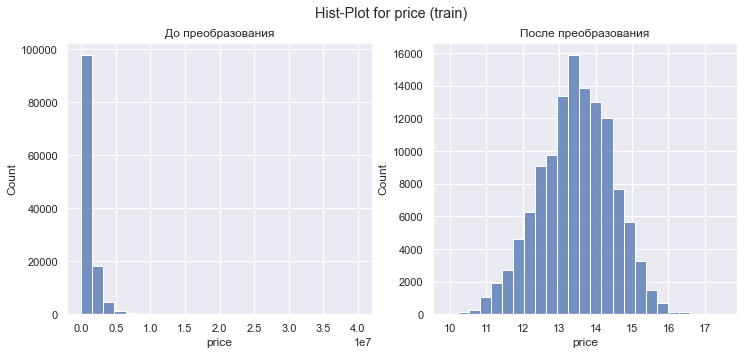

In [40]:
#Если логорифмировать
dp.Is_need_transform(df,'price', np.log)

<span style='color:Red'> ***Здесь и далее я использую импортируемые функции из модулей, которые были написаны мною. Я решил их разделить на разные блоки, чтобы было удобнее работать (уменьшает длину кода). Также практически опущены комментарии к такому роду графиков - было/стало (так как они все однотипные и EDA не так важны).*** </span>

***Видно, что целевой признак имеет экспоненциальное распределение. С таким видом будет неудобно работать, поэтому приведем его к виду нормальному с помощью логарифмирования.Признак log_price в дальнейшем будет целевым. Метрика mape будет определяться именно для price (необходима будет пост-обработка предсказаний - возведение в степень экспоненты).***

In [41]:
#Создание признака: логорифмированная цена
df['log_price'] = df['price'].apply(np.log)

## 4.2) date_year

In [42]:
#Распределение значений
df['date_year'].unique()

array(['2021', '2020', '2017', '2019', '2018', None, '2016', '2015',
       '2014', nan, '2013', 2020, '2012'], dtype=object)

***Признак содержит пропуски и пропущенные значений, заменим их для удобства обработки.***

In [43]:
#Изменение вида
df['date_year'] = df['date_year'].apply(lambda x: int(x) if str(x) != 'nan' and str(x) != 'None' else np.nan)

***Так как почти все объявления для обучающей выборки соответствуют 2021 году, а для тестовой 2020 году, то заменим пропущенные значения в датасете данными годами.***

In [44]:
#Замена пропущенных значений
df.loc[df['Kaggle']==0,'date_year'] = df.loc[df['Kaggle']==0,'date_year'].fillna(2021)
df.loc[df['Kaggle']==1,'date_year'] = df.loc[df['Kaggle']==1,'date_year'].fillna(2020)

In [45]:
#Изменение вида
df['date_year'] = df['date_year'].astype(int)

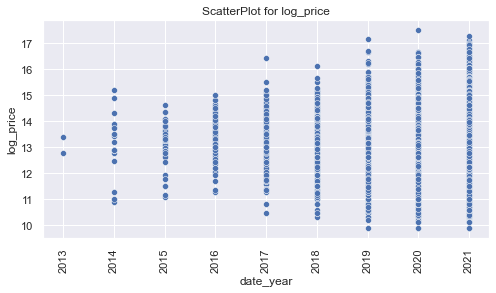

Корреляция с целевым признаком: 0.199.


In [46]:
#Распределение
viz.show_scatterplot('date_year','log_price',df,size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','date_year']].corr().iloc[0,1]))

***Между годом объявления и стоимость машины есть небольшая корреляция - с ростом года, растет и цена.***

<span style='color:Red'> ***Все выводы по пунктам 4.2-4.4 приведены в пункте 4.14.*** </span>

## 4.3) date_month

<span style='color:Red'> ***Аналогично date_year.*** </span>

In [47]:
#Распределение значений
df.groupby('Kaggle')['date_month'].value_counts(dropna=False)

Kaggle  date_month
0       апреля        46596
        марта         28167
        февраля       12560
        января         7313
        декабря        5830
        ноября         4623
        октября        3530
        мая            3268
        июня           2972
        июля           2867
        сентября       2690
        августа        2465
        NaN             151
1       октября       13597
        сентября       6002
        августа        2847
        ноября         2482
        июля           1934
        июня           1343
        декабря        1291
        марта          1170
        февраля        1004
        мая             973
        января          918
        апреля          883
        NaN             242
Name: date_month, dtype: int64

In [48]:
#Изменение вида
df['date_month'] = df['date_month'].apply(lambda x: x if str(x) != 'nan' and str(x) != 'None' else np.nan)

In [49]:
#Замена пропущенных значений
df.loc[df['Kaggle']==0,'date_month'] = df.loc[df['Kaggle']==0,'date_month'].fillna('апреля')
df.loc[df['Kaggle']==1,'date_month'] = df.loc[df['Kaggle']==1,'date_month'].fillna('октября')

In [50]:
#Замена
df['date_month'].replace({'января':1,
                          'февраля':2,
                          'марта':3,
                          'апреля':4,
                          'мая':5,
                          'июня':6,
                          'июля':7,
                          'августа':8,
                          'сентября':9,
                          'октября':10,
                          'ноября':11,
                          'декабря':12,},inplace=True)

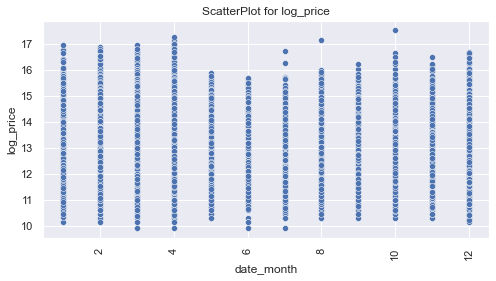

Корреляция с целевым признаком: -0.091.


In [51]:
#Распределение
viz.show_scatterplot('date_month','log_price',df,size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','date_month']].corr().iloc[0,1]))

***Между месяцем объявления и стоимость машины отсутсвует корреляция. Но есть ощущение, что цена в течение года меняется волнообразно (падает и растет по месяцам).***

<span style='color:Red'> ***Все выводы по пунктам 4.2-4.4 приведены в пункте 4.14.*** </span>

## 4.4) date_day

<span style='color:Red'> ***Аналогично date_year.*** </span>

In [52]:
#Уникальные значения
df['date_day'].unique()

array(['25', '7', '13', '15', '17', '31', '2', '19', '24', '10', '21',
       '29', '5', '12', '8', '14', '27', '28', '18', '11', '9', '30', '3',
       '4', '6', '22', '1', '23', '16', '20', '26', '', nan], dtype=object)

In [53]:
#Изменение вида
df['date_day'] = df['date_day'].apply(lambda x: x if str(x) != 'nan' and str(x) != '' else np.nan)

In [54]:
#Словарь для замены
dict_day = df.groupby(['Kaggle','date_year','date_month'])['date_day'].value_counts()
#Замена пропущенных значений
df.loc[df['date_day'].isna(), 'date_day'] = df.loc[df['date_day'].isna(),['Kaggle','date_year','date_month']].\
                                    apply(lambda x: dict_day[x[0]][x[1]][x[2]].index[0],axis=1)

In [55]:
#Замена типа
df['date_day'] = df['date_day'].astype('int')

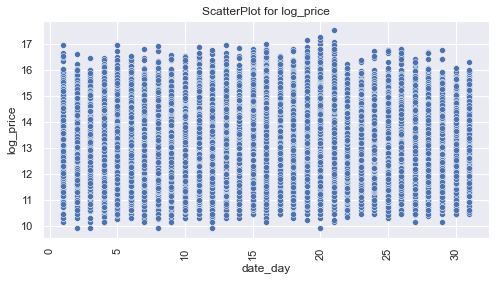

Корреляция с целевым признаком: -0.007.


In [56]:
#Распределение
viz.show_scatterplot('date_day','log_price',df,size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','date_day']].corr().iloc[0,1]))

***Между днем в месяце объявления и стоимость машины отсутсвует корреляция.***

<span style='color:Red'> ***Все выводы по пунктам 4.2-4.4 приведены в пункте 4.14.*** </span>

## 4.5) url

***Выведем по моему мнению одни из самых важных признаков: бренд и модель машины.***

In [57]:
#Создание нового признака: бренд и модель
df['brand'] = df['url'].apply(lambda x: x.split('/')[6:8])
df['model'] = df['brand'].apply(lambda x: x[1])
df['brand'] = df['brand'].apply(lambda x: x[0])

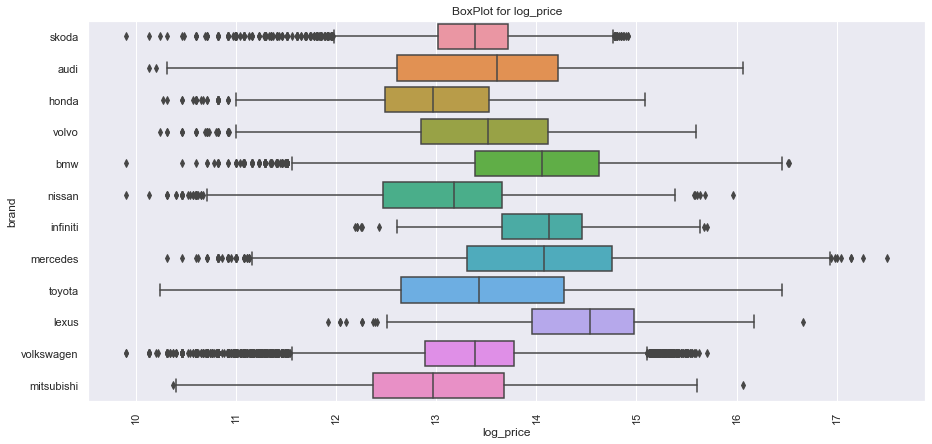

In [58]:
#Box-Plot
viz.show_boxplot('log_price','brand',df.query('Kaggle==0'),size=(15,7))

<span style='color:Red'> ***Так как на моменте парсинга данных было принято решение, что собираются данные только для брендов и моделей, представленных в тестовой выборке, то количество значений по данному признаку строго лимитировано.*** </span>

***По Box-Plot видно, что, в нашем понимании, премиум-бренды, такие как lexus, bmw, mercedes имеют в среднем цену выше, чем у прочих брендов. Самые дешевые в среднем являются mitsubishi и honda. Также можно обратить внимание на количество выбросов: это можно объяснить тем, что на сайте auto.ru есть объявления как по практически новым машинам, относительно новым и в "хлам" убитых или "потертых временем". Дело в том, что на все эти четыре группы, цены будут сильно отличаться, даже если эти машины идентичные на момент их первой покупки в автосалоне. Чем хуже техническое состояние машины, тем ниже ее цена. Также на разброс по бренду влияет и то, что каждый бренд может содержать как премиум-модели, так и эконом-модели. Все эти факторы необходимо как-то учесть.***

In [59]:
#Создание нового признака: страна-производитель
dict_country = {
    'skoda': 'chech',
    'volvo': 'sweden',
    'honda': 'japan',
    'nissan': 'japan',
    'toyota': 'japan',
    'mitsubishi': 'japan',
    'lexus': 'japan',
    'infiniti': 'japan',
    'mercedes': 'germany',
    'volkswagen': 'germany',
    'audi': 'germany',
    'bmw': 'germany'
}
df['country_brand'] = df['brand'].replace(dict_country)

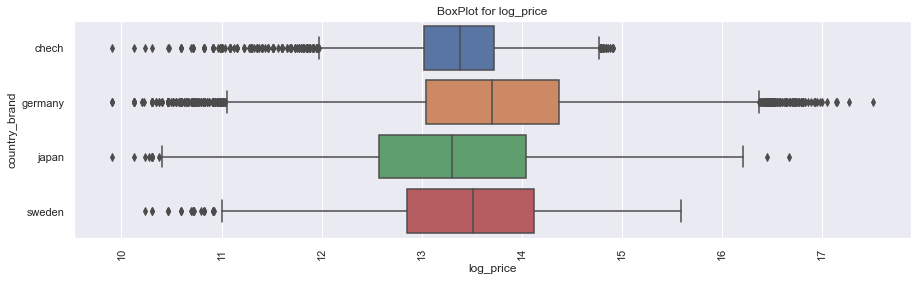

In [60]:
#Box-Plot
viz.show_boxplot('log_price','country_brand',df.query('Kaggle==0'),size=(15,4))

***На удивление, самые дешевые в среднем получились японские машины. Но совсем не удивительно, что самые дорогие вообще и самые дорогие в среднем - немецкие. Попробуем дополнительно разбить данный признак с учетом элитности брендов.***

In [61]:
#Создание нового признака: страна-производитель (v.2)
dict_country = {
    'skoda': 'chech',
    'volvo': 'sweden',
    'honda': 'japan',
    'nissan': 'japan',
    'toyota': 'japan',
    'mitsubishi': 'japan',
    'lexus': 'japan_best',
    'infiniti': 'japan_best',
    'volkswagen': 'germany',
    'audi': 'germany',
    'mercedes': 'germany_best',
    'bmw': 'germany_best'
}
df['country_v2_brand'] = df['brand'].replace(dict_country)

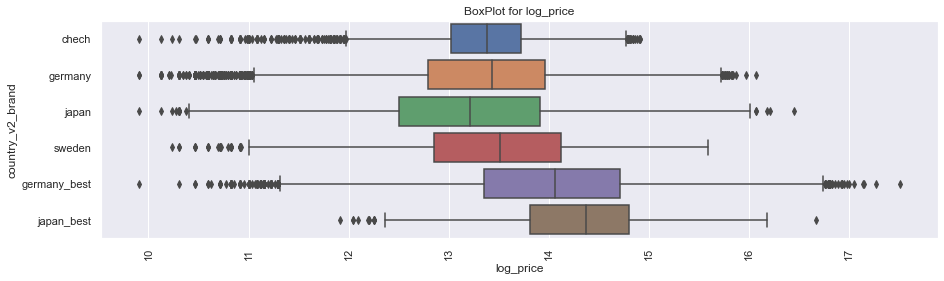

In [62]:
#Box-Plot
viz.show_boxplot('log_price','country_v2_brand',df.query('Kaggle==0'),size=(15,4))

***На данном графике уже более отчетливо видно, что в среднем самыми дорогими являются японские автомобили марок lexus и infiniti, затем знаметитые немецкие bmw и mercedes. Далее почти одинаковое значение средней цены на немецкие-эконом, чешские и шведские автомобили. И самые дешевые: с азиатского рынка.***

In [63]:
#Создание нового признака: лучший бренд
dict_best_brand = {
    'skoda': 0,
    'nissan': 0,
    'volkswagen': 0,
    'mitsubishi': 0,
    'toyota': 0,
    'honda': 0,
    'volvo': 0,
    'bmw': 1,
    'audi': 1,
    'infiniti': 1,
    'mercedes': 1,
    'lexus': 1
}
df['best_brand'] = df['brand'].replace(dict_best_brand).apply(str)

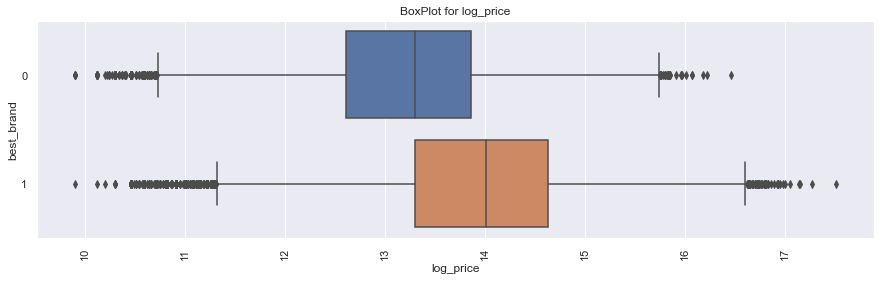

In [64]:
#Box-Plot
viz.show_boxplot('log_price','best_brand',df.query('Kaggle==0'),size=(15,4))

***По графику видно, что премиум бренды, как их принято называть, в среднем стоят значительно больше, чем обычные бренды.***

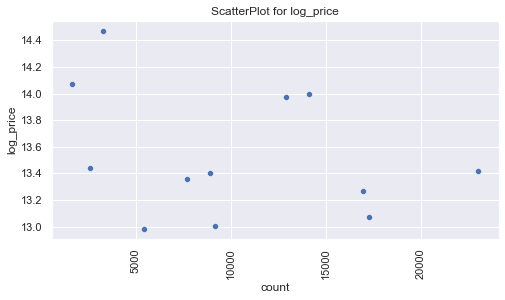

Корреляция с целевым признаком: -0.061.


In [65]:
#Кол-во объявлений по бренду
df_brand = pd.DataFrame()
df_brand['count'] = df.query('Kaggle==0').groupby('brand')['url'].agg('count')
df_brand['log_price'] = df.query('Kaggle==0').groupby('brand')['log_price'].agg('mean')
#Распределение
viz.show_scatterplot('count','log_price',df_brand,size=(8,4))
#Создание нового признака: количество объявлений по данному бренду
df['count_brand'] = df['brand'].replace(dict(df_brand.iloc[:,0]))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','count_brand']].corr().iloc[0,1]))

***Количество брендов очень мало, поэтому какую-либо зависимость построить сложно по 12 точкам.***

<span style='color:Red'> ***Я решил оставить данный признак, может он окажется важным в процессе построения деревьев решений, лесов и т.д.*** </span>

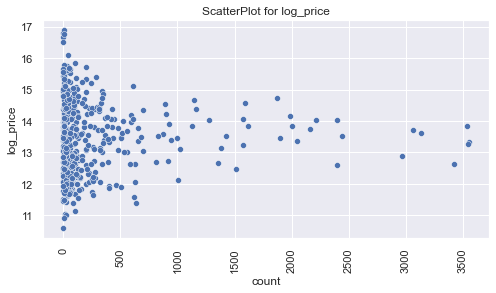

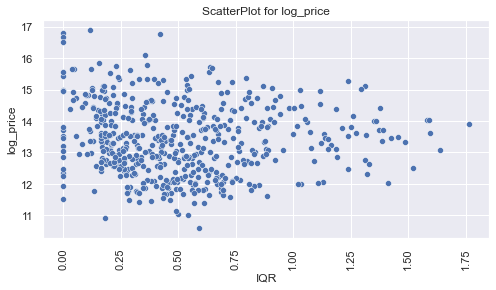

In [66]:
#Кол-во объявлений по модели
df_model = pd.DataFrame()
df_model['count'] = df.query('Kaggle==0').groupby('model')['url'].agg('count')
df_model['log_price'] = df.query('Kaggle==0').groupby('model')['log_price'].agg('mean')
df_model['IQR'] = df.query('Kaggle==0').groupby('model')['log_price'].agg(lambda x: x.quantile(0.75) - x.quantile(0.25))
#Распределение
viz.show_scatterplot('count','log_price',df_model,size=(8,4))
viz.show_scatterplot('IQR','log_price',df_model,size=(8,4))

***Попытка определить корреляцию между ценой и межквартильным размахом и количеством объвлений по модели не привело ни к чему хорошему. Корреляция практически нулевая.***

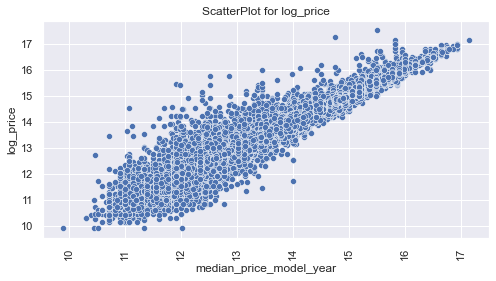

Корреляция с целевым признаком: 0.976.


In [67]:
#Словарь: медианная цена на модель и год
dict_med_price_2 = dict(df.query('Kaggle==0').groupby(['model','year'])['log_price'].agg('median'))
other_value = df.query('Kaggle==0').groupby(['model','year'])['log_price'].agg('median').median()
df['median_price_model_year'] = df[['model','year']].\
    apply(lambda x: dict_med_price_2[(x[0],x[1])] if (x[0],x[1]) in dict_med_price_2.keys() else other_value, axis=1)
#Распределение
viz.show_scatterplot('median_price_model_year','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','median_price_model_year']].corr().iloc[0,1]))

***Признаки модель + год модели и цена сильно скореллированы между собой. С одной стороны - это хорошо, так как повыситься точность предсказаний. С другой стороны - это может привести к переобучению и практически полному изучению моделью обучающей выборки.***

<span style='color:Red'> ***Опытным путем было установлено, что данный признак является скорее важным и полезным, чем нет. При его отсутствии получаемая точность по метрике MAPE на валидационной и тестовой выборках снижалась на 3-5% в зависимости от модели.*** </span>

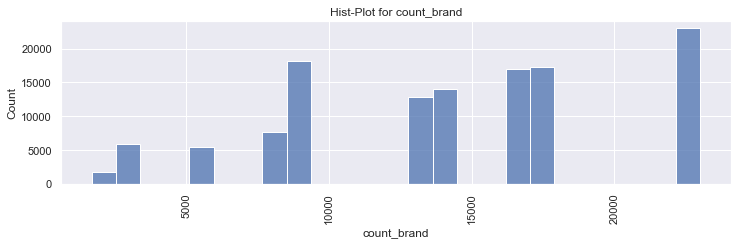

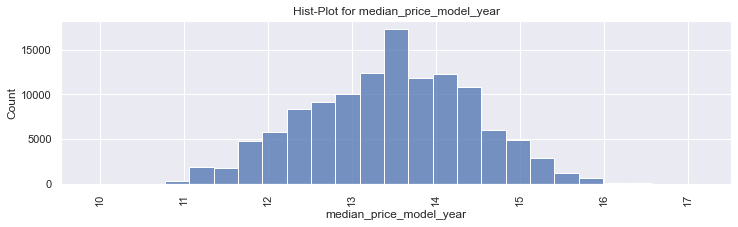

In [68]:
#Гистограмма распределений добавленных признаков
for col in ['count_brand','median_price_model_year']:
    viz.show_histplot(col,df.query('Kaggle==0'),size=(12,3),bins=25)

***Признак median_price_model_year распределен нормально,а count содержит строго ограниченное число значений, поэтому его преобразование является некореектным.***

In [69]:
#Запись столбца в группу
col_bin += ['best_brand']
col_cat += ['brand','model','country_brand','country_v2_brand']
col_num += ['count_brand','median_price_model_year']

## 4.6) year, mileage

In [70]:
#Замена типа
df[['year','mileage']] = df[['year','mileage']].astype('int')

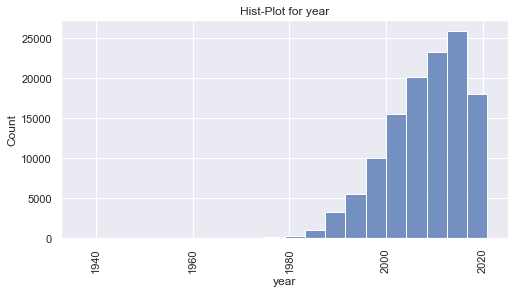

In [71]:
#Гистограмма
viz.show_histplot('year',df.query('Kaggle==0'),bins=20)

***Признак year имеет нормальное распределение со смещение влево. Это можно объяснить тем, что в осномном на auto.ru публикуют объявления по новым и относительно новым машинам, и гораздо реже по антиквариату (хвост слева). Преобразование для данного признака не требуется.***

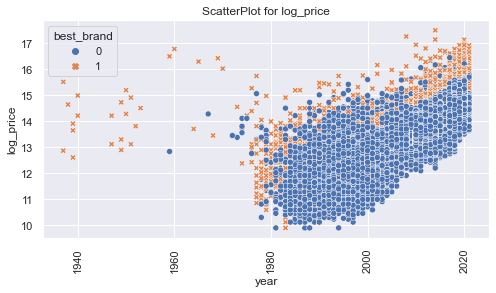

In [72]:
#Зависимость цены от годы
viz.show_scatterplot('year','log_price',df.query('Kaggle==0'),hue='best_brand',size=(8,4))
#Создание нового признака: старая раритетная машина
df['rarity_car'] = df['year'].apply(lambda x: int(x < 1977))

***Видно, что с ростом года модели растет и его цена за исключением машин до 1977 года. Скорее всего это антиквариат (раритетные машины), которые имеют коллекционную ценность, поэтому так дорого и стоят.***

***На примере данного графика объясним почему при достаточно низком смещении получается высокая дисперсия на практически любой зависимости Y(X), где Y - целевой признак. Все дело в том, что каждому значению X (в данном случаю году модели) может соответствовать как набор дешевых автомобилей, так и набор дорогих (на примере year: допустим в 2000 год были выпущены, как 2000 машин Opel (низкая цена), так и 2000 машин BMW (высокая цена), но при этом в среднем на одни и те же марки с течением года цена растет). С чем это может быть связано?***

***Логично первое, что бросается в голову, что цена на машины растет каждый год из-за банальной инфляции. Что скорее всего и есть правда, но с точки зрения статистики это необходимо подтвердить гипотезой с некоторой доли вероятности. Здесь я этого делать не буду, но отмечу еще возможные варианты причины роста цены: люди стали чаще выкладывать дорогие автомобили, чем дешевые, при том, что цена на них не меняется критично, но в итоге будет видна корреляция между ценой (НА АВТО.РУ) и годом модели.***

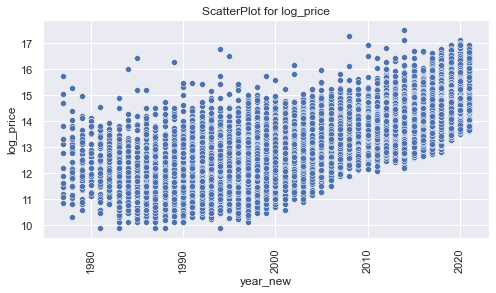

Корреляция с целевым признаком: 0.824.


In [73]:
#Создание нового признака: новый год
df['year_new'] = df['year'].apply(lambda x: x if x >= 1977 else 2*1977-x)
#Зависимость цены от годы
viz.show_scatterplot('year_new','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','year_new']].corr().iloc[0,1]))

***Применим эвристику и уберем эти значения "раритетных" годов путем разворота их относительно 1977 года. Получили высокую положительную корреляцию с целевым признаком.***

Признак mileage преобразован. Количество признаков до: 1640; после 403; сокращено: 1237.


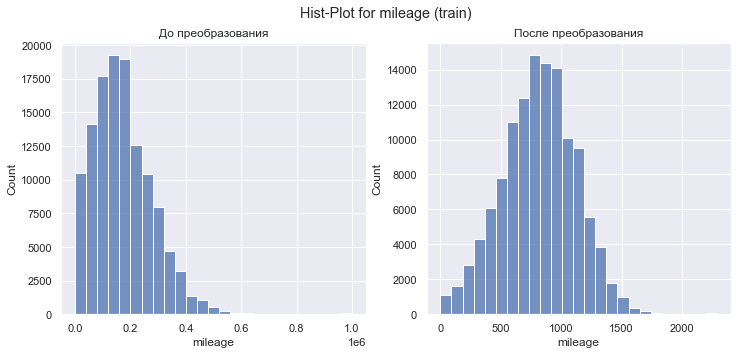

In [74]:
#Если преобразовать
dp.Is_need_transform(df,'mileage', lambda x: x**0.56)
#Правка признака
df['mileage'] = df['mileage'].apply(lambda x: x**0.56)

***После преобразования признака mileage - километраж машины, количество выбросов было сокращено в 4 раза. Это некритичное изменение для деревьев решений, но может быть полезным для линейной модели, например. После преобразования признак имеет нормальный вид.***

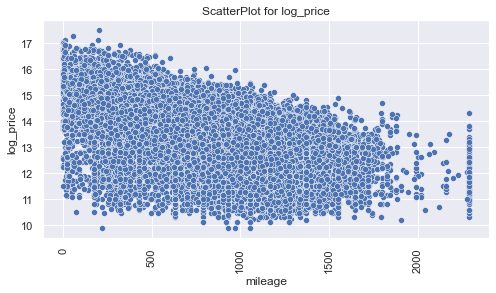

Корреляция с целевым признаком: -0.639.


In [75]:
#Зависимость цены от пробега
viz.show_scatterplot('mileage','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','mileage']].corr().iloc[0,1]))

***Получена логичная отрицательная корреляция: чем больше пробег, тем ниже цена.***

In [76]:
#Запись столбца в группу
col_num += ['year','year_new','mileage']
col_bin += ['rarity_car']

## 4.7) pts

In [77]:
#Распределение значений
df.groupby('Kaggle')['pts'].value_counts(dropna=False)

Kaggle  pts     
0       Оригинал    101839
        Дубликат     21193
1       Оригинал     29796
        Дубликат      4889
        NaN              1
Name: pts, dtype: int64

In [78]:
#Замена пропусков
df['pts'].fillna('Оригинал',inplace=True)

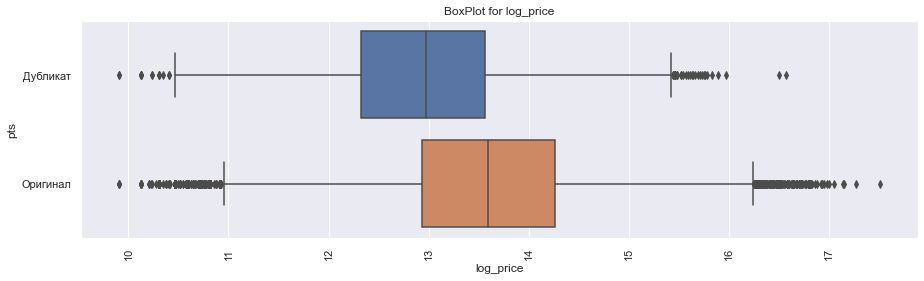

In [79]:
#Box-Plot
viz.show_boxplot('log_price','pts',df.query('Kaggle==0'),size=(15,4))

***Также логичное распределение: объявления с дубликатом ПТС стоят дешевле, так как машина либо часто меняла владельца (см.пункт 4.11), либо последний владелец "намеренно" испортил по причине сокрытия нежелательной информации. И то, и то снижает цену.***

In [80]:
#Запись столбца в группу
col_bin += ['pts']

## 4.8) char_engine

In [81]:
#Осмотр данных
df['char_engine'].head(3)

0    [1.4, 122, Бензин]
1    [1.6, 102, Бензин]
2    [1.6, 110, Бензин]
Name: char_engine, dtype: object

In [82]:
#Создание новых признаков: тип двигателя, мощность двигателя, объем двигателя
df['type_engine'] = df['char_engine'].apply(lambda x: x[-1])
df['power_engine'] = df['char_engine'].apply(lambda x: int(x[1]))
df['volume_engine'] = df['char_engine'].apply(lambda x: float(x[0]))

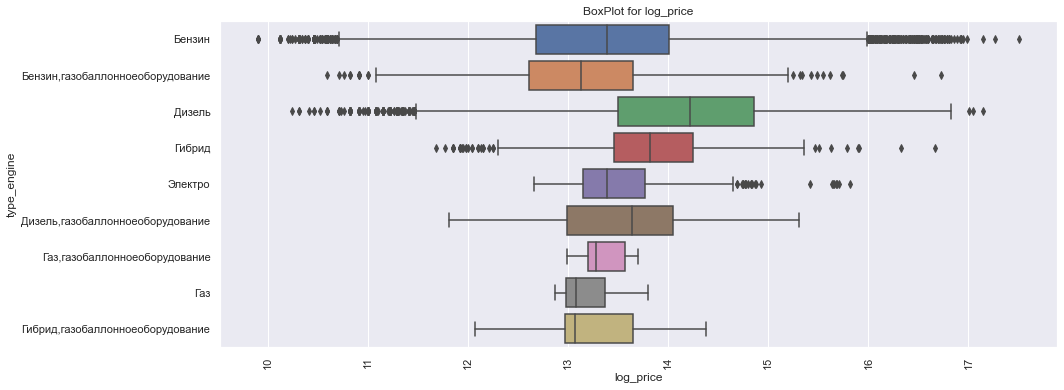

In [83]:
#Box-Plot
viz.show_boxplot('log_price','type_engine',df.query('Kaggle==0'),size=(15,6))

***Значений признака слишком много и они дублируют друг друга, преобразуем данный признак и повторим Box-Plot.***

In [84]:
#Поиск не совпадений
dp.intersection_data(df.query('Kaggle==0'),df.query('Kaggle==1'),['type_engine'])

Признак type_engine.
    Пропуски в train: ['бензин', 'дизель', 'гибрид', 'электро'].
    Пропуски в test:  ['Гибрид,газобаллонноеоборудование'].
    Количество пропусков в train: 0
    Количество пропусков в test:  0
    Количество уникальных элементов: 13
    Уникальные элементы: {'Бензин,газобаллонноеоборудование', 'Гибрид', 'Дизель,газобаллонноеоборудование', 'Дизель', 'гибрид', 'Газ', 'дизель', 'Электро', 'электро', 'Гибрид,газобаллонноеоборудование', 'бензин', 'Газ,газобаллонноеоборудование', 'Бензин'}



In [85]:
#Замена значений для уменьшения размерности
df['type_engine'].replace({'бензин': 'Бензин',
                           'дизель': 'Дизель',
                           'гибрид': 'Гибрид',
                           'электро': 'Электро',
                           'Бензин,газобаллонноеоборудование': 'Бензин',
                           'Газ,газобаллонноеоборудование': 'Газ',
                           'Дизель,газобаллонноеоборудование': 'Дизель',
                           'Гибрид,газобаллонноеоборудование': 'Гибрид'}, inplace=True)

In [86]:
#Поиск не совпадений
dp.intersection_data(df.query('Kaggle==0'),df.query('Kaggle==1'),['type_engine'])

Признак type_engine.
    Пропуски в train: [].
    Пропуски в test:  [].
    Количество пропусков в train: 0
    Количество пропусков в test:  0
    Количество уникальных элементов: 5
    Уникальные элементы: {'Гибрид', 'Дизель', 'Газ', 'Электро', 'Бензин'}



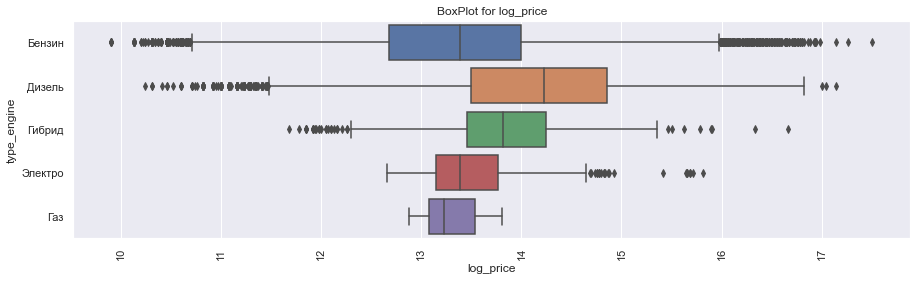

In [87]:
#Box-Plot
viz.show_boxplot('log_price','type_engine',df.query('Kaggle==0'),size=(15,4))

***Самые дорогие машины в среднем с двигателем на дизеле, затем на гибридном топливе. Цепочку замыкают машины на бензине и электро-кары. Также стоит отметить, что группы машин на бензине и дизеле имеют самый высокий IQR, что объясняется скорее популярностью данных моделей (больше объявлений). Машины группы 'Газ' самые дешевые и самые малочисленные среди прочих.***

In [88]:
#Уникальные значения
np.sort(df['volume_engine'].unique())

array([  0.7,   0.9,   1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,
         1.7,   1.8,   1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,
         2.6,   2.7,   2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,
         3.5,   3.6,   3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,
         4.4,   4.5,   4.6,   4.7,   4.8,   4.9,   5. ,   5.2,   5.3,
         5.4,   5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.2,   6.3,
         6.6,   6.8,  30. ,  49. ,  80. ,  85. , 110. , 125. , 132. ,
       135. , 160. , 230. , 300. ,   nan])

In [89]:
#Медианное значение
median_ve = df['volume_engine'].median()
#Замена занчений
df.loc[df['volume_engine'] > 6.8,'volume_engine'] = median_ve
#Заполнение пропусков
df.fillna(median_ve,inplace=True)

Признак volume_engine преобразован. Количество признаков до: 8050; после 2967; сокращено: 5083.


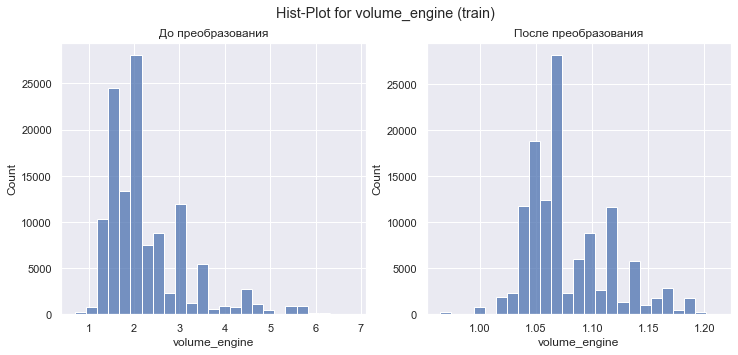

In [90]:
#Провека
dp.Is_need_transform(df,'volume_engine', lambda x: x**0.1)
#Преобразование
df['volume_engine'] = df['volume_engine'].apply(lambda x: x**0.1)

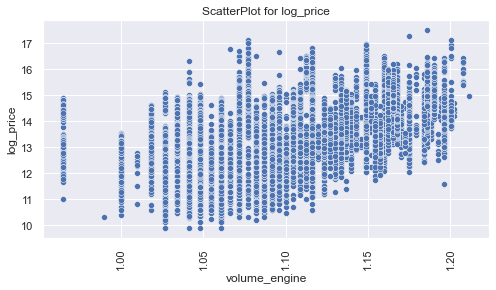

Корреляция с целевым признаком: 0.433.


In [91]:
#Зависимость цены от объема двигателя
viz.show_scatterplot('volume_engine','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','volume_engine']].corr().iloc[0,1]))

***Присутствует небольшая положительная корреляция между объемом двигателя и ценой автомобиля. В основном все значения лежат в интервале от 1.5 до 2.3 л3 (до преобразования), а прочие скорее являются выбросами.***

Признак power_engine преобразован. Количество признаков до: 4819; после 1094; сокращено: 3725.


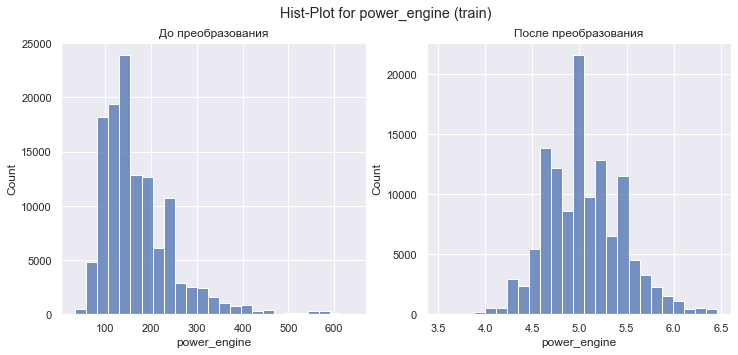

In [92]:
#Провека
dp.Is_need_transform(df,'power_engine', lambda x: np.log(x))
#Преобразование
df['power_engine'] = df['power_engine'].apply(lambda x: np.log(x))

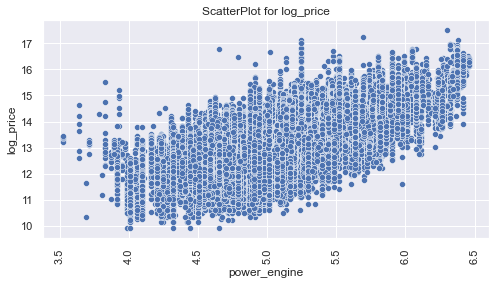

Корреляция с целевым признаком: 0.628.


In [93]:
#Зависимость цены от мощности двигателя
viz.show_scatterplot('power_engine','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','power_engine']].corr().iloc[0,1]))

***Присутствует значимая положительная корреляция между мощностью двигателя и ценой автомобился, что логично: мощные автомобили стоят дороже (спорт-кары, элитные-бренды).***

In [94]:
#Удаление столбца
df.drop(columns=['char_engine'],inplace=True)

In [95]:
#Запись столбца в группу
col_num += ['volume_engine','power_engine']
col_cat += ['type_engine']

## 4.9) equipment

***С одной стороны признак очень полезен, но он содержит множество уникальных значений, что затрудняет его обработку. Принято решение оставить до лучших времен.***

In [96]:
#Удаление столбца
df.drop(columns=['equipment'],inplace=True)

## 4.10) type_body

In [97]:
#Поиск не совпадений
dp.intersection_data(df.query('Kaggle==0'),df.query('Kaggle==1'),['type_body'])

Признак type_body.
    Пропуски в train: [].
    Пропуски в test:  ['универсал 3 дв.'].
    Количество пропусков в train: 0
    Количество пропусков в test:  0
    Количество уникальных элементов: 25
    Уникальные элементы: {'внедорожник 5 дв.', 'седан-хардтоп', 'фастбек', 'хэтчбек 3 дв.', 'тарга', 'пикап полуторная кабина', 'седан', 'компактвэн', 'фургон', 'лифтбек', 'пикап одинарная кабина', 'кабриолет', 'купе', 'внедорожник 3 дв.', 'родстер', 'микровэн', 'купе-хардтоп', 'универсал 3 дв.', 'минивэн', 'хэтчбек 5 дв.', 'пикап двойная кабина', 'внедорожник открытый', 'универсал 5 дв.', 'седан 2 дв.', 'лимузин'}



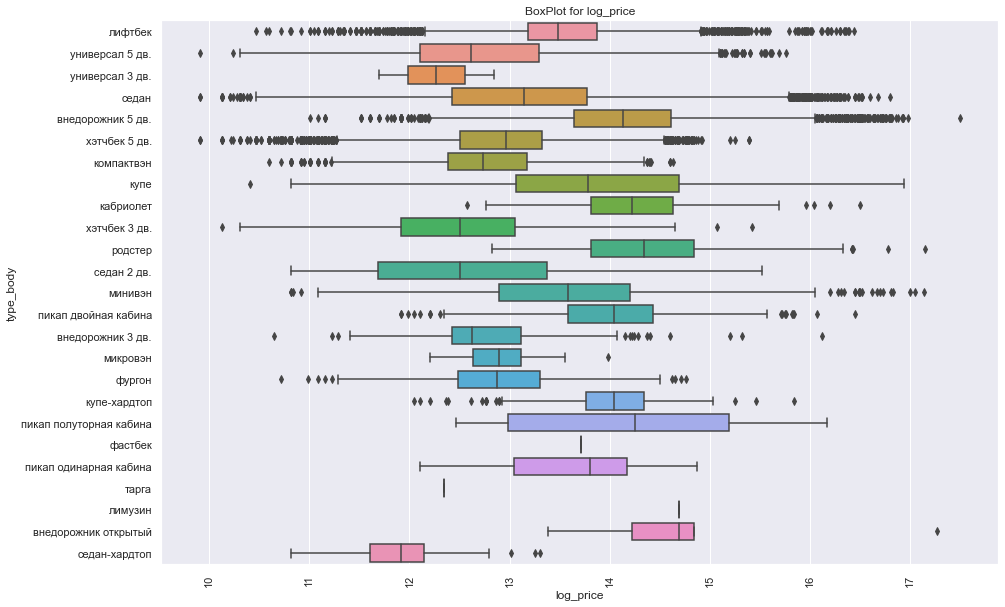

In [98]:
#Box-Plot
viz.show_boxplot('log_price','type_body',df.query('Kaggle==0'),size=(15,10))

***Реорганизуем признак и повторим Box-Plot. Уменьшим количество значений по признаку, сократив практически однотипные категории.***

In [99]:
#Переименование параметров
df['type_body'].replace({
    'кабриолет': 'родстер_лимузин_кабриолет',
    'родстер':'родстер_лимузин_кабриолет',
    'лимузин':'родстер_лимузин_кабриолет',
    'пикап одинарная кабина':'пикап',
    'пикап полуторная кабина':'пикап',
    'пикап двойная кабина':'пикап',
    'внедорожник 3 дв.':'внедорожник',
    'внедорожник открытый':'внедорожник',
    'внедорожник 5 дв.':'внедорожник',
    'хэтчбек 5 дв.':'хэтчбек',
    'хэтчбек 3 дв.':'хэтчбек',
    'седан-хардтоп':'седан',
    'седан 2 дв.':'седан',
    'фастбек':'седан',
    'тарга':'седан',
    'минивэн':'вэн',
    'микровэн':'вэн',
    'компактвэн':'вэн',
    'фургон':'вэн',
    'универсал 5 дв.':'универсал',
    'универсал 3 дв.':'универсал',
    'купе-хардтоп':'купе'    
}, inplace=True)

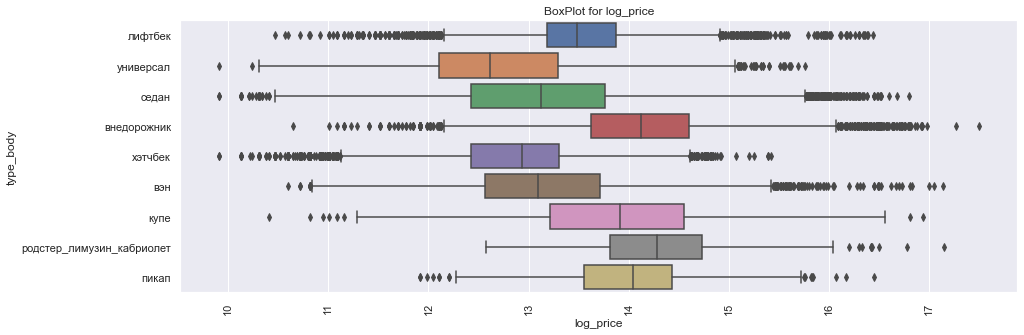

In [100]:
#Box-Plot
viz.show_boxplot('log_price','type_body',df.query('Kaggle==0'),size=(15,5))

***По результатам графика получены следующие выводы: логично, что самые дорогие автомобили - это кабриолеты, лимузины, родстеры и внедорожники. Также купе, пикап. Самые дешевые - хэтчбэки и универсалы. К категории средней можно отнести: седан, вэн. Самые многочисленные группы, такие как седан, внедорожник, хэтчбэк имеют множество выбросов.***

In [101]:
#Распределение параметра
df['type_body'].value_counts()

седан                        62550
внедорожник                  53171
хэтчбек                      12889
вэн                           8751
лифтбек                       8513
универсал                     6871
купе                          3174
пикап                         1356
родстер_лимузин_кабриолет      443
Name: type_body, dtype: int64

In [102]:
#Запись столбца в группу
col_cat += ['type_body']

## 4.11) color, type_transmission, type_drive, type_wheel, count_owners

In [103]:
#Поиск не совпадений по всем номинативным параметрам
dp.intersection_data(df.query('Kaggle==0'),df.query('Kaggle==1'),\
                     ['color','type_transmission','type_drive','type_wheel','count_owners'])

Признак color.
    Пропуски в train: [].
    Пропуски в test:  [].
    Количество пропусков в train: 0
    Количество пропусков в test:  0
    Количество уникальных элементов: 16
    Уникальные элементы: {'пурпурный', 'оранжевый', 'белый', 'голубой', 'синий', 'фиолетовый', 'жёлтый', 'розовый', 'красный', 'чёрный', 'бежевый', 'серый', 'зелёный', 'коричневый', 'золотистый', 'серебристый'}

Признак type_transmission.
    Пропуски в train: [].
    Пропуски в test:  [].
    Количество пропусков в train: 0
    Количество пропусков в test:  0
    Количество уникальных элементов: 4
    Уникальные элементы: {'роботизированная', 'механическая', 'вариатор', 'автоматическая'}

Признак type_drive.
    Пропуски в train: [].
    Пропуски в test:  [].
    Количество пропусков в train: 0
    Количество пропусков в test:  0
    Количество уникальных элементов: 3
    Уникальные элементы: {'задний', 'передний', 'полный'}

Признак type_wheel.
    Пропуски в train: [].
    Пропуски в test:  [].
    Количест

***Отсутствующих значений в обучающей выборке нет, что хорошо.***

In [104]:
#Замена значений
df['count_owners'].replace({1:'1',2:'2',3:'3+'},inplace=True)

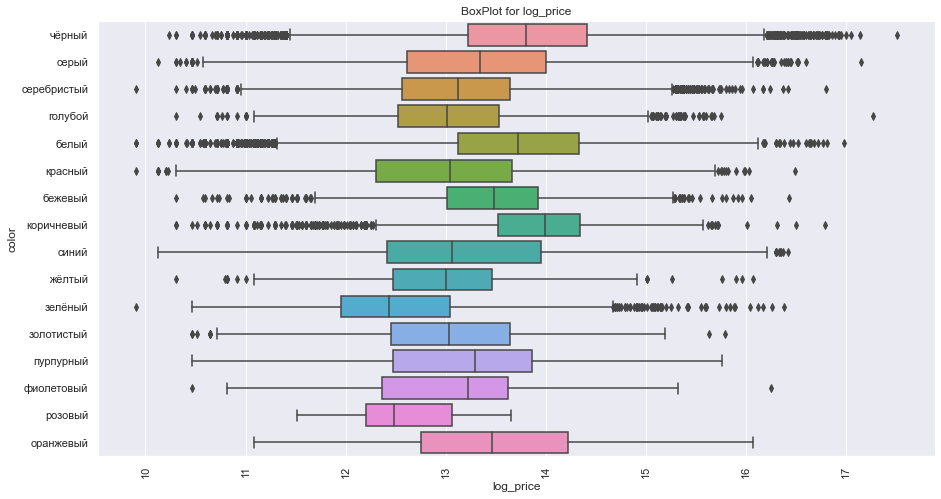

In [105]:
#Box-Plot
viz.show_boxplot('log_price','color',df.query('Kaggle==0'),size=(15,8))

***Самые дорогие машины с цветом коричневый, белый и черный. Самый дешевый - зеленый, розовый. Остальные - в среднем +- одиновы. Количество значений признаков слишком велико, но сходу в голову не приходит, как их можно реорганизовать.***

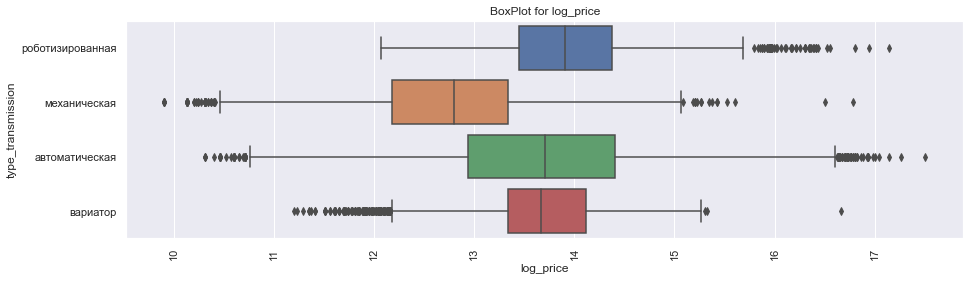

In [106]:
#Box-Plot
viz.show_boxplot('log_price','type_transmission',df.query('Kaggle==0'),size=(15,4))

***Машины с механическим типом трансмиссии самые дешевые, остальные примерно на одном уровне. Малый IQR групп 'вариатор', 'роботизированная' можно объяснить тем, что количество значений в них ощутимо мало по сравнению с остальными группами.***

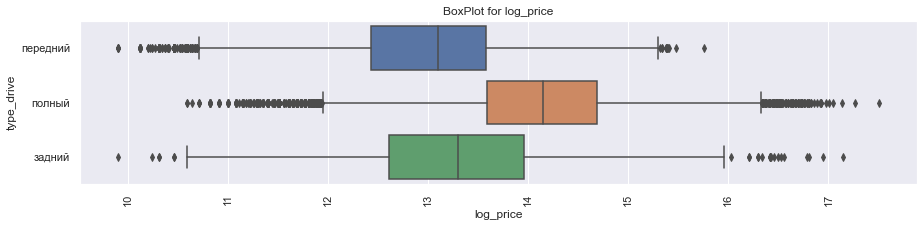

In [107]:
#Box-Plot
viz.show_boxplot('log_price','type_drive',df.query('Kaggle==0'),size=(15,3))

***Машины на полном приводе стоят дороже, чем машины на заднем или переднем приводах.***

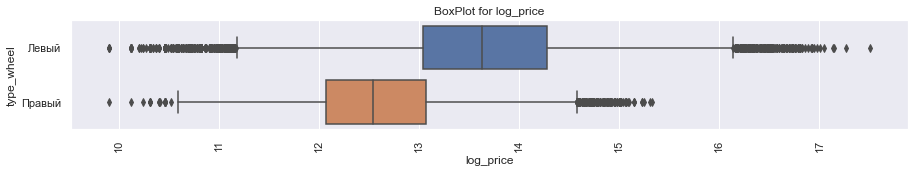

In [108]:
#Box-Plot
viz.show_boxplot('log_price','type_wheel',df.query('Kaggle==0'),size=(15,2))

***Машины с правым рулем стоят ощутимо дешевле, чем машины с левым рулем. Что логично, так как сайт ориентирован на русский рынок и такая "экзотика" никому не сдалась на наших дорогах - вызывает кучу неудобств при эксплуатации изделия.***

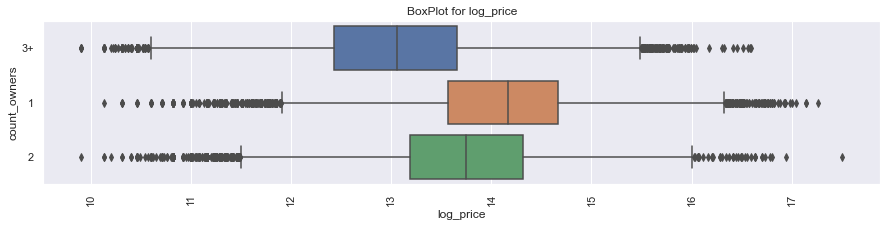

In [109]:
#Box-Plot
viz.show_boxplot('log_price','count_owners',df.query('Kaggle==0'),size=(15,3))

***Видна отрицателья корреляция между число владельцев машины и ее стоимостью.***

In [110]:
#Распределение параметров
for col in ['color','type_transmission','type_drive','count_owners','type_wheel']:
    print(df.query('Kaggle==0')[col].value_counts(),end='\n'*2)

чёрный         32758
белый          27179
серебристый    16304
серый          16281
синий          10721
красный         5454
коричневый      4291
зелёный         3611
бежевый         1821
голубой         1455
золотистый       945
пурпурный        726
фиолетовый       665
жёлтый           399
оранжевый        335
розовый           87
Name: color, dtype: int64

автоматическая      67461
механическая        29891
вариатор            14922
роботизированная    10758
Name: type_transmission, dtype: int64

передний    61541
полный      46432
задний      15059
Name: type_drive, dtype: int64

3+    64818
1     30228
2     27986
Name: count_owners, dtype: int64

Левый     103895
Правый     19137
Name: type_wheel, dtype: int64



In [111]:
#Запись столбца в группу
col_cat += ['color','type_transmission','type_drive','count_owners']
col_bin += ['type_wheel']

## 4.12) +df_rating

***Склеиваем исходный DataFrame с признаком rating, собранным по моделям по версии auto.ru.***

In [112]:
#Оформление DF
df_rating = df_rating.set_index(['brand','model'])
#Join
df = pd.concat([df,df[['brand','model']].apply(lambda x: df_rating.loc[(x[0],x[1])], axis=1)],axis=1)

In [113]:
#Осмотр пропусков
df.isna().sum()

url                             0
year                            0
mileage                         0
type_body                       0
color                           0
type_transmission               0
type_drive                      0
type_wheel                      0
count_owners                    0
pts                             0
price                           0
Kaggle                          0
date_day                        0
date_month                      0
date_year                       0
log_price                       0
brand                           0
model                           0
country_brand                   0
country_v2_brand                0
best_brand                      0
count_brand                     0
median_price_model_year         0
rarity_car                      0
year_new                        0
type_engine                     0
power_engine                    0
volume_engine                   0
rating                        590
count_plus    

***Столбцы count_plus и count_minus содержат множество пропусков, такое, что их заполнение скорее испортит признак. Поэтому принято решение их удалить.***

In [114]:
#Удаление столбцов
df.drop(columns=['count_plus','count_minus'],inplace=True)

In [115]:
#Замена пропусков
df.loc[df['rating'].isna(), 'rating'] = df[df['rating'].isna()]['brand'].replace(dict(df.groupby('brand')['rating'].agg('mean').round(1)))

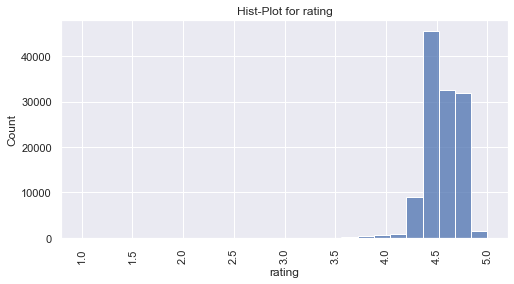

In [116]:
#Гистограмма
viz.show_histplot('rating',df.query('Kaggle==0'),bins=25)

***В основном все модели имеют рейтинг от 4.4 до 4.8.***

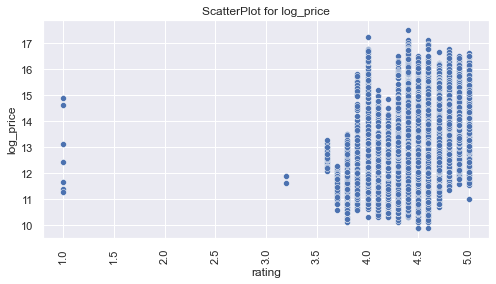

In [117]:
#Зависимость цены от рейтинга машины
viz.show_scatterplot('rating','log_price',df.query('Kaggle==0'),size=(8,4))

***Значения меньше 3.7 являются следствием обработки (замены пропусков). Если открыть данные модели на auto.ru, то можно обнаружить, что информации по ним нет. Применим эвристику и вручную обработаем признаки.***

In [118]:
#Правка
df['rating'] = df['rating'].apply(lambda x: 3.7 if x < 3.7 else x)

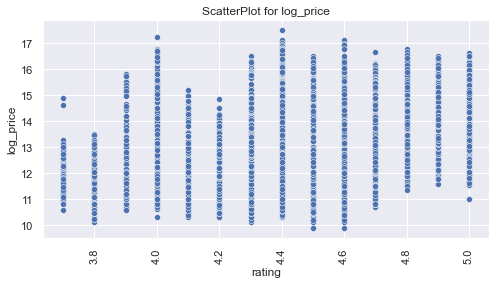

Корреляция с целевым признаком: 0.484.


In [119]:
#Зависимость цены от рейтинга машины
viz.show_scatterplot('rating','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','rating']].corr().iloc[0,1]))

***Есть значимая положительная корреляция между рейтингом и ценой машины.***

In [120]:
#Запись столбца в группу
col_num += ['rating']

## 4.13) +df_price

***Склеиваем исходный DataFrame с признаком price, собранным по моделям по версии auto.ru.***

In [121]:
#Оформление DF
df_price = df_price.set_index(['brand','model'])
#Join
df = pd.concat([df,df[['brand','model']].apply(lambda x: df_price.loc[(x[0],x[1])], axis=1)],axis=1)

In [122]:
#Пропущенные значения
df.groupby('Kaggle').agg(lambda x: x.isna().sum())

url  year  mileage  type_body  color  type_transmission  type_drive  \
Kaggle                                                                        
0         0     0      0.0          0      0                  0           0   
1         0     0      0.0          0      0                  0           0   

        type_wheel  count_owners  pts  ...  year_new  type_engine  \
Kaggle                                 ...                          
0                0             0    0  ...         0            0   
1                0             0    0  ...         0            0   

        power_engine  volume_engine  rating  price_autoru  price_per  \
Kaggle                                                                 
0                0.0            0.0     0.0       18667.0    21635.0   
1                0.0            0.0     0.0        3271.0     3799.0   

        day_mean  day_opt  count_review  
Kaggle                                   
0        17717.0  17717.0         18667  
1         3068.0   3068.0          3271  

[2 rows x 33 columns]

***Новые столбцы содержат больше число пропусков, но возможно эти признаки помогут повысить точность модели, попробуем обработать их, заполнив пропуски средним по группе brand.***

In [123]:
#Замена типа
df['count_review'] = df['count_review'].apply(lambda x: int(x.replace('б','6')) if type(x) != float else x)

In [124]:
#Замена пропусков
df.loc[df['price_autoru'].isna(), 'price_autoru'] = df[df['price_autoru'].isna()]['brand'].replace(dict(df.groupby('brand')['price_autoru'].agg('mean')))
df.loc[df['price_per'].isna(), 'price_per'] = df[df['price_per'].isna()]['brand'].replace(dict(df.groupby('brand')['price_per'].agg('mean')))
df.loc[df['day_mean'].isna(), 'day_mean'] = df[df['day_mean'].isna()]['brand'].replace(dict(df.groupby('brand')['day_mean'].agg('mean')))
df.loc[df['day_opt'].isna(), 'day_opt'] = df[df['day_opt'].isna()]['brand'].replace(dict(df.groupby('brand')['day_opt'].agg('mean')))
df.loc[df['count_review'].isna(), 'count_review'] = df[df['count_review'].isna()]['brand'].replace(dict(df.groupby('brand')['count_review'].agg('mean')))

Признак price_autoru преобразован. Количество признаков до: 5106; после 1149; сокращено: 3957.


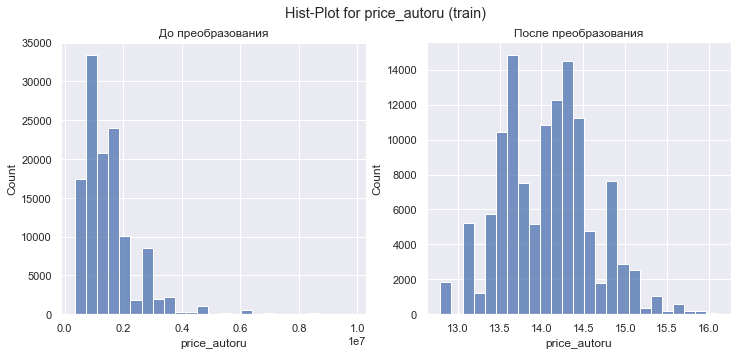

In [125]:
#Провека
dp.Is_need_transform(df,'price_autoru', lambda x: np.log(x))
#Преобразование
df['price_autoru'] = df['price_autoru'].apply(lambda x: np.log(x))

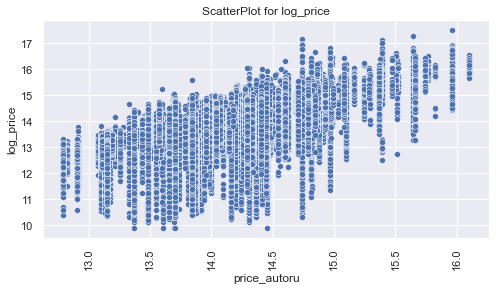

Корреляция с целевым признаком: 0.511.


In [126]:
#Зависимость цены от цены на авто-ру
viz.show_scatterplot('price_autoru','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','price_autoru']].corr().iloc[0,1]))

***Есть значимая положительная корреляция между ценой на автомобиль и ценой на его модель на сайте auto.ru. Два данных признака одинаковы по смыслу и в идеальном случае должны иметь одно значение, но отклонение, а именно высокий разброс можно объяснить, что одна и та же модель может отличаться по цене из-за технического состояния модели, года ее выпуска, цвета и т.д.***

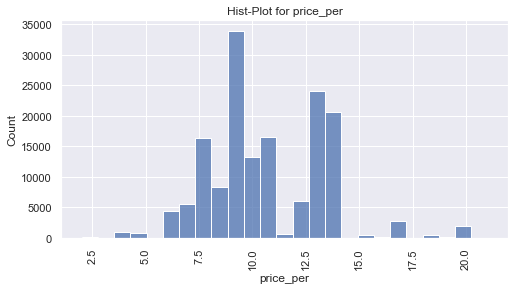

In [127]:
#Гистограмма
viz.show_histplot('price_per',df,bins=25)

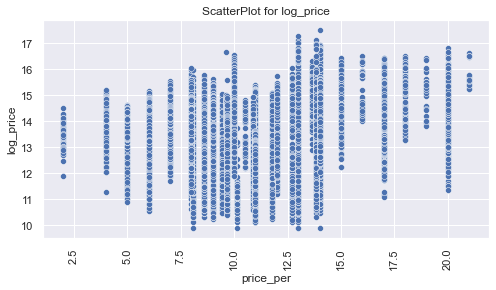

Корреляция с целевым признаком: 0.168.


In [128]:
#Зависимость цены от уровня падения цены за последний год
viz.show_scatterplot('price_per','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','price_per']].corr().iloc[0,1]))

***Падение цены с течением временем на модель слабо скореллировано с целевым признаком.***

Признак day_mean преобразован. Количество признаков до: 3916; после 3232; сокращено: 684.


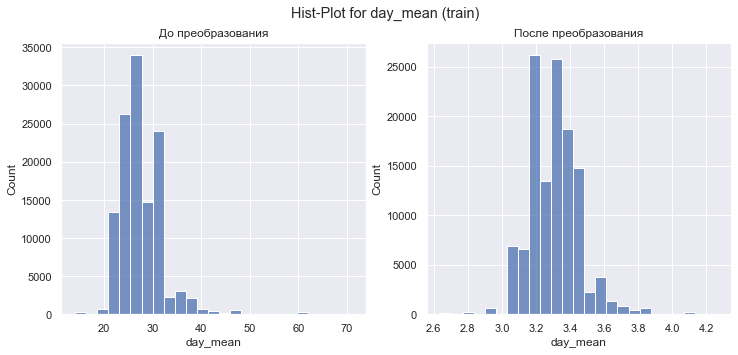

In [129]:
#Провека
dp.Is_need_transform(df,'day_mean', lambda x: np.log(x))
#Преобразование
df['day_mean'] = df['day_mean'].apply(lambda x: np.log(x))

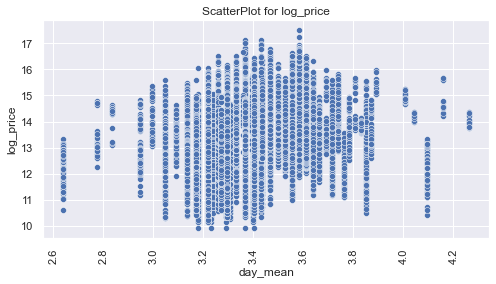

Корреляция с целевым признаком: 0.171.


In [130]:
#Зависимость цены от кол-ва дней (в среднем) за сколько покупают машину
viz.show_scatterplot('day_mean','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','day_mean']].corr().iloc[0,1]))

***Присутствует слабая положительная корреляция между ценой и количеством дней между опубликованием объявления и совершением сделки. Положительность корреляции можно объяснить тем, что для более дорогих автомобилей покупатель ищется гораздо дольше, чем для дешевых (видимо этот тип покупателя занимает значительную часть рынка auto.tu).***

In [131]:
#Удаление столбца
df.drop(columns=['day_opt','price_per'],inplace=True)

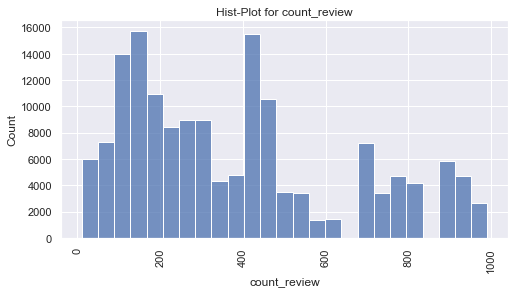

In [132]:
#Гистограмма
viz.show_histplot('count_review',df,bins=25)

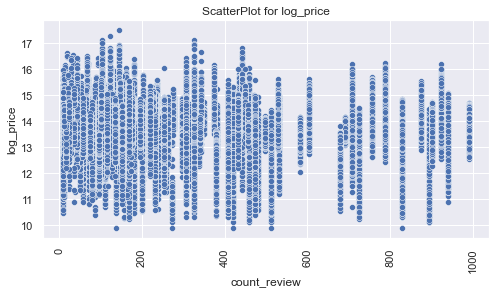

Корреляция с целевым признаком: -0.046.


In [133]:
#Зависимость цены от количества отзывов
viz.show_scatterplot('count_review','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','count_review']].corr().iloc[0,1]))

***Никакой корреляции с целевым признаком нет. Удаляем его.***

In [134]:
#Удаление столбца
df.drop(columns=['count_review'],inplace=True)

In [135]:
#Запись столбца в группу
col_num += ['price_autoru','day_mean']

## 4.14) date

***Используем ранее собранные признаки года, месяца и дня, чтобы создать столбец с типом datetime.***

In [136]:
#Создание нового признака: дата опубликования объявления
df['date'] = pd.to_datetime((df['date_year']*10000+\
                             df['date_month']*100+\
                             df['date_day']).apply(str), format='%Y%m%d')

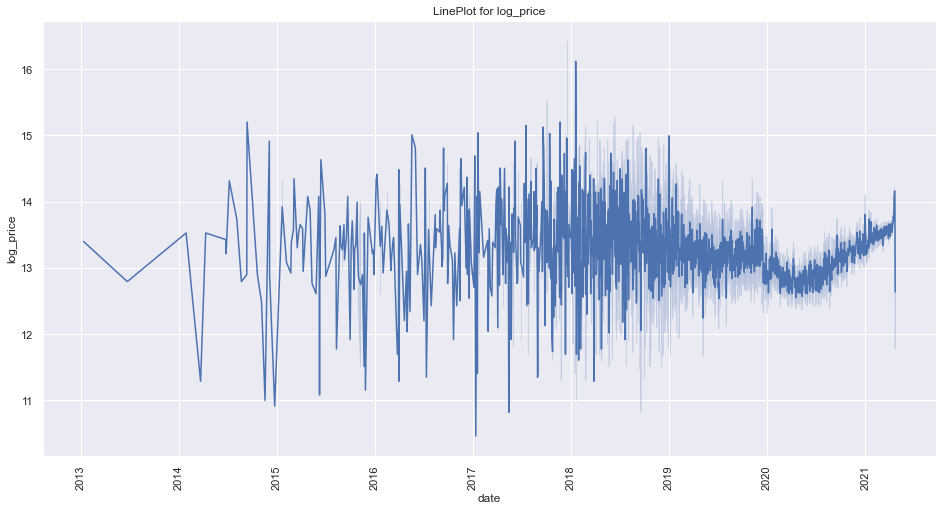

In [137]:
#Зависимость цены от даты публикации
viz.show_lineplot('date','log_price',df.query('Kaggle==0'),size=(16,8))

***Перед составлением выводов по данному графику немного реорганизуем его: значений до 2019 года очень мало, избавимся от них.***

In [138]:
#Распределение значений
df['date_year'].value_counts()

2021    85104
2020    59861
2019    10410
2018     1707
2017      378
2016      137
2015       86
2014       32
2013        2
2012        1
Name: date_year, dtype: int64

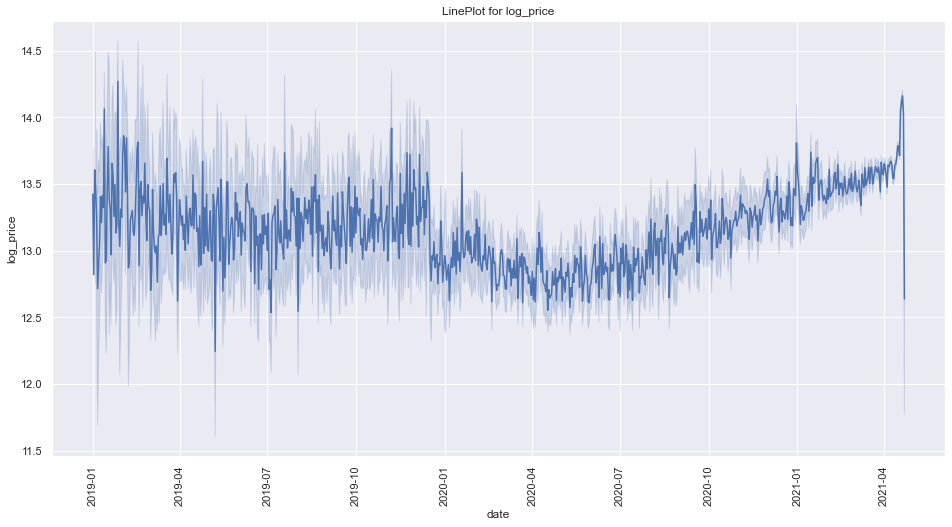

In [139]:
#Зависимость цены от даты публикации
viz.show_lineplot('date','log_price', df.query('Kaggle==0 & date_year >=2019'),size=(16,8))

***С графика видно, что с среднем цена на машины в течении 2019 года держалась на одном уровне. Лишь в предверии нового года цены обвалились в предверии новогодних скидок и праздников. Также можно отметить, что все-таки цены в течение года не статичные, а имеют синусоидальный характер. Сразу после нового 2020 года цены начали расти, что логично, и после ажиотажа наблюдается спад, как и в 2019 за тот же период до марта месяца. Далее, так как сайт auto.tu ориентирован на российский рынок, наблюдается резкий скачок и затем медленно ползучий вверх рост цен. Это можно объяснить эпидемией коронавируса в России, которая началась именно в тот период, и кризисом, последовавшим за этим (подтверждение - это также зависимостью курса доллара в течение 2020 года).***

***Очень важный вывод, который нужно сделать по всей работе относиться к этому графику: к сожалению, как мне кажется, чем позже студент выполняет работу относительно момента осени 2020 года, тем хуже будет его метрика на Kaggle, представленная именно этим периодом (при прочих равных). Я могу объяснить это так:***

***1. Сама модель будет зависеть от того на каких данных мы ее обучим, то есть за какой период мы их соберем.***

***2. Данные для обучения, собранные за период, когда цены были выше, будут в итоге обучать модель более высоким ценам в сравнении с ценами осени 2020 года.***

***3. Очень сильно зависит качество собранных данных от социальных факторов за данный период. Например, если вдруг окажется, что в силу того или иного фактора резко все ринулись продавать дорогие машины, то обучающая выборка будет содержать в основном преценденты с высокой ценой. Аналогично может быть и с низкой ценой. Но что хуже - это резкий скачок цены: если внезапно окажется, что машина, например, bmw x5, окажется популярной, то и цена на нее взлетит (например вышел фильм Бумер 3), но это не значит, что на эту же машину осенью 2020 года была такая же высокая/низкая цена.***

***Поэтому финальные предсказания перед отправкой на Kaggle нужно домножать на коэффициент, учитывающий инфляцию, кризис и соц. условия.***

<span style='color:Red'> ***Опытным путем было установлено, что данный коэффициент равен 0.9. Отношение курса тогда и сейчас примерно равно ~0.9-0.95. Дополнительное повышение цен можно связать с пост-короновирусным кризисом.*** </span>

In [140]:
#Сегодня
now = datetime(2021, 4, 22)
#Создание нового признака: разница между сегодня и датой объявления - возраст объявления
df['age_ad'] = (now - df['date']).dt.days
#Создание нового признака: разница между датой объявления и годом модели - возраст машины
df['age_car'] = df[['date','year']].apply(lambda x: x[0] - datetime(x[1],1,1), axis=1).dt.days
#Создание нового признака: средний срок владения одним владельцем машины в днях
df['mean_time_owner'] = df['age_car'] / df['count_owners'].replace({'1':1,'2':2,'3+':3})
#Создание нового признака: средний пробег машины за день
df['mileage_per_day'] = df['mileage'] / df['age_car']

<span style='color:Red'> ***Как уже было сказано ранее: не получилось собрать признак - год производства автомобиля. Поэтому возраст автомобиля вычисляется не от момента его производства, а от момента первого выпуска однотипной модели - года модели.*** </span>

Признак age_ad преобразован. Количество признаков до: 14339; после 0; сокращено: 14339.


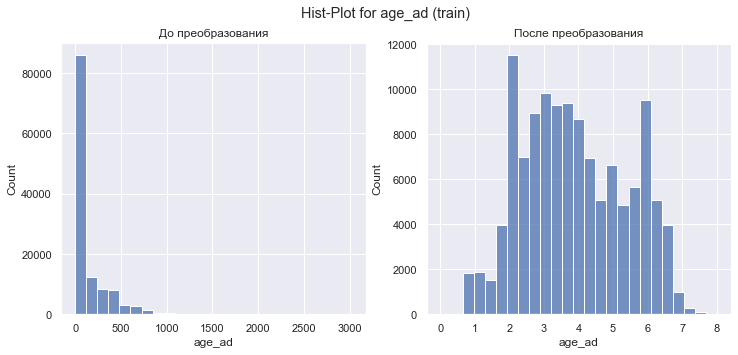

In [141]:
#Провека
dp.Is_need_transform(df,'age_ad', lambda x: np.log(1+x))
#Преобразование
df['age_ad'] = df['age_ad'].apply(lambda x: np.log(1+x))

***Признак имел экспоненциальное распределение, с помощью логарифмирования удалось полностью избавиться от выбросов.***

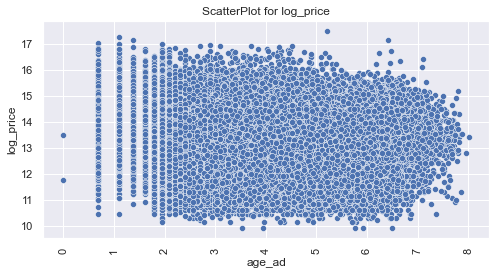

Корреляция с целевым признаком: -0.277.


In [142]:
#Зависимость
viz.show_scatterplot('age_ad','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','age_ad']].corr().iloc[0,1]))

***Весьма неоднозначная отрицательная корреляция: чем старше объявление, тем ниже цена. Хотя опять же это можно объяснить ростом цен.***

Признак age_car преобразован. Количество признаков до: 654; после 618; сокращено: 36.


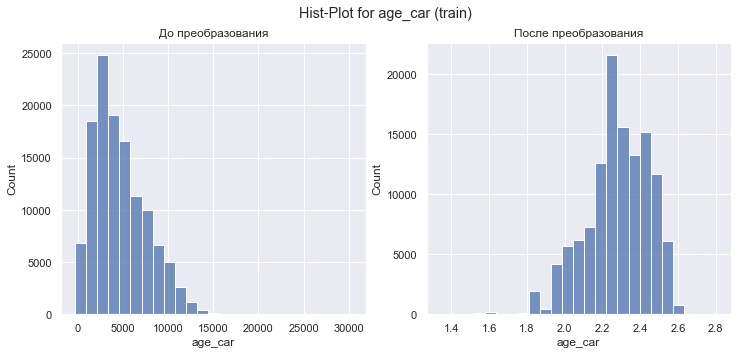

In [143]:
#Провека
dp.Is_need_transform(df,'age_car', lambda x: abs(x)**0.1)
#Преобразование
df['age_car'] = df['age_car'].apply(lambda x: abs(x)**0.1)

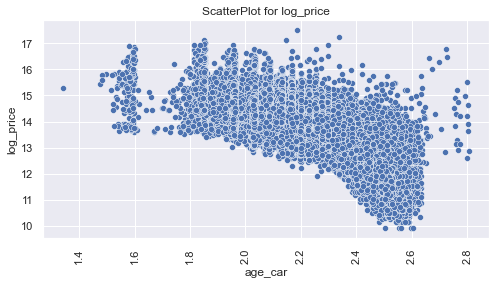

Корреляция с целевым признаком: -0.797.


In [144]:
#Зависимость
viz.show_scatterplot('age_car','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','age_car']].corr().iloc[0,1]))

***Получена сильная отрицательная корреляция: с ростом возраста машины падает ее цена.***

Признак mean_time_owner преобразован. Количество признаков до: 4226; после 1513; сокращено: 2713.


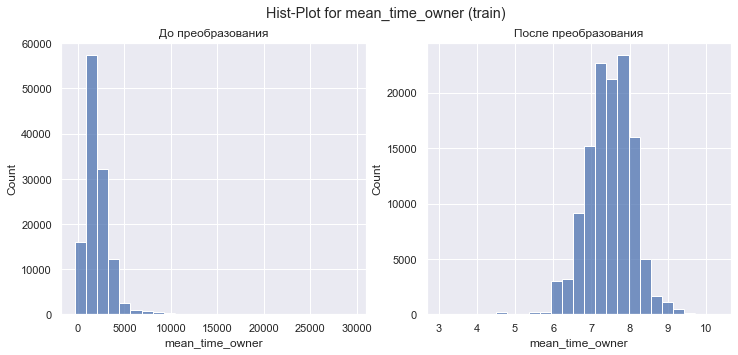

In [145]:
#Провека
dp.Is_need_transform(df,'mean_time_owner', lambda x: np.log(2+x))
#Преобразование
df['mean_time_owner'] = df['mean_time_owner'].apply(lambda x: np.log(1+x))
#Замена пропусков
df['mean_time_owner'].fillna(df['mean_time_owner'].min(),inplace=True)

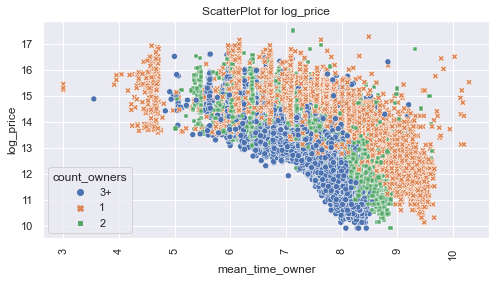

Корреляция с целевым признаком: -0.632.


In [146]:
#Зависимость
viz.show_scatterplot('mean_time_owner','log_price',df.query('Kaggle==0'),hue='count_owners',size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','mean_time_owner']].corr().iloc[0,1]))

***Получена сильная отрицательная корреляция: с ростом времени владения автомобилем одним владельцем падает цена на автомобиль. Интересным является то, что для машин с одним владельцем значения признака mean_time_owner в среднем выше, и с повышением count_owners понижается среднее mean_time_owner.***

Признак mileage_per_day преобразован. Количество признаков до: 5777; после 4699; сокращено: 1078.


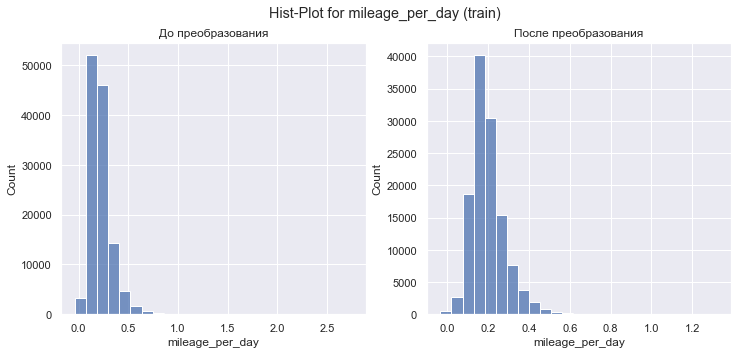

In [147]:
#Провека
dp.Is_need_transform(df,'mileage_per_day', lambda x: np.log(1+x))
#Преобразование
df['mileage_per_day'] = df['mileage_per_day'].apply(lambda x: np.log(1+x))

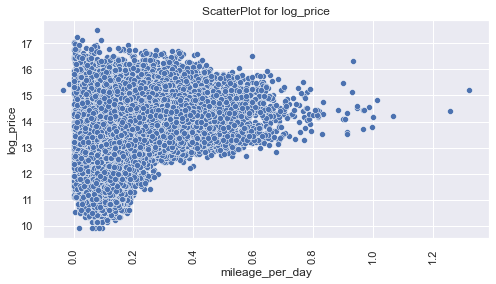

Корреляция с целевым признаком: 0.564.


In [148]:
#Зависимость
viz.show_scatterplot('mileage_per_day','log_price',df.query('Kaggle==0'),size=(8,4))
#Корреляция с целевым признаком
print('Корреляция с целевым признаком: {:.3f}.'.format(df[['log_price','mileage_per_day']].corr().iloc[0,1]))

***Получена довольно не очевидная и странная положительная корреляция: с ростом пробега за день растет и цена. По логике - цена должна падать, так как с ростом пробега за день растет износ автомобиля, а соответственно ухудшается его техническое состояние, соответственно и цена. Это можно объяснить скорее невидимым промежуточным признаком между ценой и средним пробегом (как размер обуви и роста человека) или случайностью при сборе данных (что именно за период 2021 года, именно так карты выпали, что с ростом среднего пробега растет и цена).***

In [149]:
#Удаление столбца
df.drop(columns=['date','date_year','date_month','date_day'],inplace=True)

In [150]:
#Запись столбца в группу
col_num += ['age_ad','age_car','mean_time_owner','mileage_per_day']

# 5. Пост-обработка данных

## 5.1) Таблица корреляций для числовых признаков

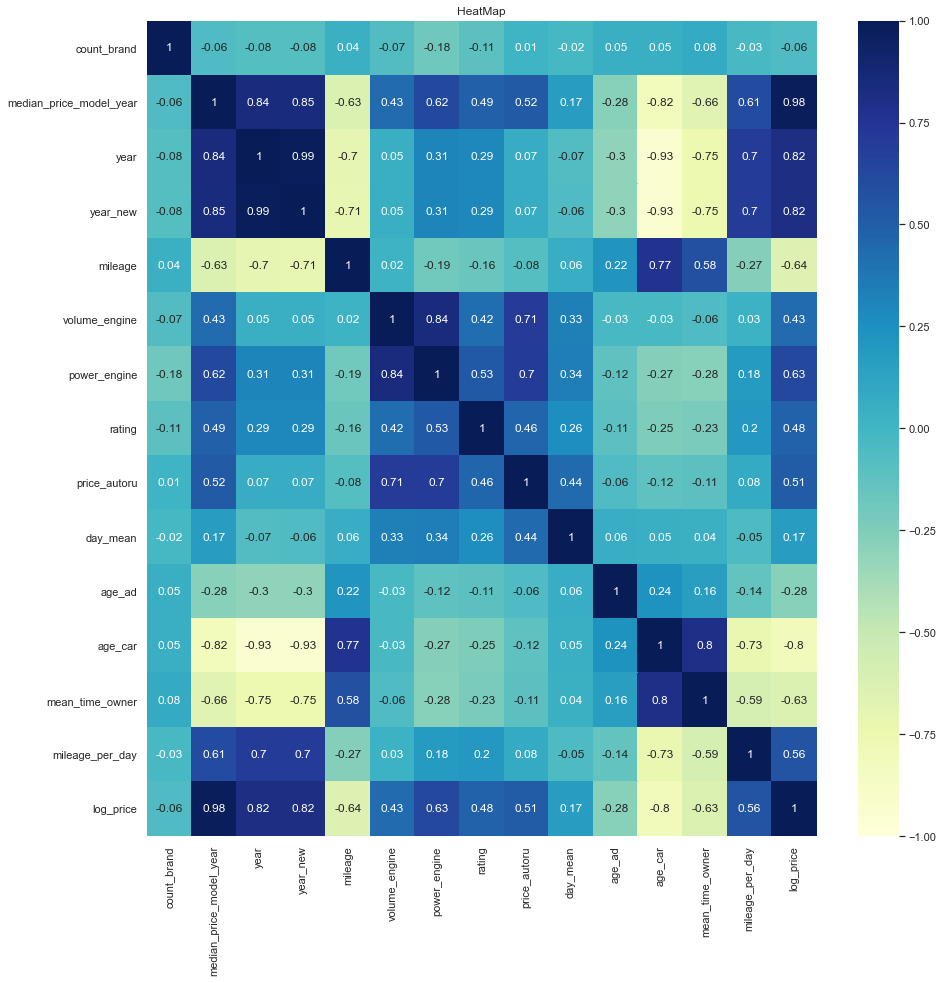

In [151]:
#Тепловая карта
viz.show_Heatmap(df.query('Kaggle==0'),cols=col_num+['log_price'],size=(15,15))

***Самый сильный скоррелированный признак - year. Удалим его.***

In [152]:
#Удаление коррелирующих признаков
df.drop(columns=['year'])
col_num.remove('year')

<span style='color:Red'> ***Еще среди сильно скоррелированных признаков есть age_car, но практика показала, что его лучше не удалять - метрика стала хуже. Скорее всего, это можно объяснить сильной корреляцией с целевым признаком.*** </span>

## 5.2) Работа с выбросами

***Определим количество выбросов на первой итерации.***

In [153]:
#Количество выбросов по числовым параметрам
for col in col_num:
    n_drop = dp.count_drop_num(df,col)
    print('Признак {} содержит выбросов: {}.'.format(col, n_drop))

Признак count_brand содержит выбросов: 0.
Признак median_price_model_year содержит выбросов: 258.
Признак year_new содержит выбросов: 2287.
Признак mileage содержит выбросов: 1190.
Признак volume_engine содержит выбросов: 985.
Признак power_engine содержит выбросов: 1389.
Признак rating содержит выбросов: 2736.
Признак price_autoru содержит выбросов: 1633.
Признак day_mean содержит выбросов: 3762.
Признак age_ad содержит выбросов: 0.
Признак age_car содержит выбросов: 2584.
Признак mean_time_owner содержит выбросов: 2292.
Признак mileage_per_day содержит выбросов: 6292.


In [154]:
#Количество выбросов целевого признака
print('Целевой признак {} содержит выбросов: {}.'.\
      format('price', dp.count_drop_num(df.query('Kaggle==0'),'price')))
print('Целевой признак {} содержит выбросов: {}.'.\
      format('log_price', dp.count_drop_num(df.query('Kaggle==0'),'log_price')))

Целевой признак price содержит выбросов: 8272.
Целевой признак log_price содержит выбросов: 455.


***Уже на первой итерации количество выбросов превышает 5000. Попробуем это обработать.***

<span style='color:Red'> ***Данная часть является самой долгой по процессу реализации и теста (из 8 рабочих дней - это заняло 6). Дело в том, что при удалении выбросов по указанным признакам ниже, метрика на обучающей и валидационной выборках растет (mape падает). Но если вообще не удалять выбросы, то растет метрика на тестовой на Kaggle, при падении на валидационной. На момент 23.04.2021 - сдачи проекта я не успеваю подобрать такие признаки, чтобы получить максимум и там, и там. Поэтому принято решение не подстраиваться под Kaggle и обучать алгоритмы с учетом выбросов.*** </span>

<span style='color:Red'> ***Дополнительное пояснение в выводе.*** </span>

In [155]:
#Копирование перед исправлением
df_drop = df.copy()
#Столбцы, по которым считаются выбросы
col_num_target = 'log_price'
col_num_drop = ['mileage','mean_time_owner']
col_nom_drop = ['brand','type_body','type_engine','type_transmission','type_drive','count_owners','pts','type_wheel']
itr,S,s = 0,0,1
max_itr = 20
while s > 0:
    s = 0
    #Начальная длина
    len_init = len(df_drop)
    #Создание признака: выброс
    df_drop.loc[:,'Is_drop'] = 0
    #Целевой
    df_drop.loc[df_drop['Kaggle']==0,'Is_drop'] = df_drop.loc[df_drop['Kaggle']==0,'Is_drop'] +\
                                             dp.Is_drop(df_drop[df_drop['Kaggle']==0],col_num_target).astype(int)
    #Количественные
    for col in col_num_drop:
        df_drop.loc[:,'Is_drop'] = df_drop['Is_drop'] + dp.Is_drop(df_drop,col).astype(int)
    #Номинативные
    for col in col_nom_drop:
        df_sub = pd.DataFrame()
        for name,group in df_drop.query('Kaggle==0').groupby(col)[col_num_target]:            
            df_sub = pd.concat([df_sub,dp.Is_drop(pd.DataFrame(group),col_num_target)])
        df_sub.sort_index(inplace=True)
        df_sub = df_sub.astype(int)
        df_drop.loc[:,'Is_drop'] = df_drop.loc[:,'Is_drop'] + df_sub[0]
    #Удаление выбросов
    df_drop.drop(index=df_drop.query('(Kaggle==0) & (Is_drop>0)').index, inplace=True)
    #Конечная длина
    len_end = len(df_drop)
    #Вывод информации
    s = len_init - len_end
    S += s
    itr += 1
    print('Итерация {}. Удалено {}. Удалено всего {}.'.format(itr,s,S))
    if itr == max_itr:
        break

Итерация 1. Удалено 6740. Удалено всего 6740.
Итерация 2. Удалено 1908. Удалено всего 8648.
Итерация 3. Удалено 869. Удалено всего 9517.
Итерация 4. Удалено 441. Удалено всего 9958.
Итерация 5. Удалено 148. Удалено всего 10106.
Итерация 6. Удалено 69. Удалено всего 10175.
Итерация 7. Удалено 16. Удалено всего 10191.
Итерация 8. Удалено 4. Удалено всего 10195.
Итерация 9. Удалено 0. Удалено всего 10195.


In [156]:
#Удаление столбца
df_drop.drop(columns=['Is_drop'],inplace=True)

## 5.3) Определение значимости признаков

In [157]:
#Номинативные признаки
for col in col_cat+col_bin:
    dp.Is_stat_dif(col,'price',df,alpha=0.05)

Статистически значим: brand
Статистически значим: model
Статистически значим: country_brand
Статистически значим: country_v2_brand
Статистически значим: type_engine
Статистически значим: type_body
Статистически значим: color
Статистически значим: type_transmission
Статистически значим: type_drive
Статистически значим: count_owners
Статистически значим: best_brand
Статистически значим: rarity_car
Статистически значим: pts
Статистически значим: type_wheel


***Все номинативные признаки являются статистически значимыми с коэффициентом доверия 0.95.***

<AxesSubplot:>

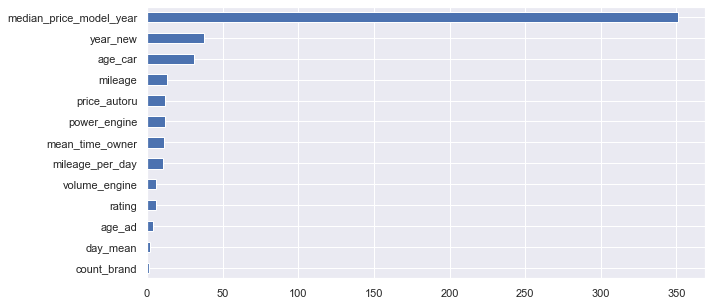

In [158]:
plt.rcParams['figure.figsize'] = (10,5)
#Числовые признаки
imp_num = pd.Series(f_classif(df_drop.query('Kaggle==0')[col_num], df_drop.query('Kaggle==0')['log_price'])[0], index=col_num)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

***Как и говорилось ранее, признак median_price_model_year является самым скоррелированым с целевым среди прочих, так как он на основе его и построен. Это может привести к переобучению (но не привело). Далее идут year_new - год модели и age_car - возраст модели. Менее значимые: mileage - пробег, mean_time_owner - время владения одним владельцем, power_engine - мощность двигателя и price_autoru - цена на модель на auto.ru.***

# 6.ML - PipeLine

## 6.1) Подготовка выборок

In [159]:
#Для вывода на Kaggle (сохранение url)
sample_submissions.loc[:,'url'] = df.loc[df['Kaggle']==1,'url'].values

***Как видно ниже, проводились тесты с удалением признаков, которые могут приводить к переобучениею. В коненом итоге используется тот набор признаков, который приведен ниже. Признак model удален из рассмотрения при построении моделей.***

In [160]:
#   #Создание нескольких выборок
#   #log
#   df_ML_1 = df.copy() #Выбросы есть. Все номинативные признаки переводим в dummy
#   df_ML_2 = df.copy() #Выбросы есть. Все номинативные признаки переводим в dummy, кроме: model 
#   df_ML_3 = df.copy() #Выбросы есть. Все номинативные признаки переводим в dummy.  median_price_model_year удаляем
#   df_ML_4 = df.copy() #Выбросы есть. Все номинативные признаки переводим в dummy, кроме: model. median_price_model_year удаляем
#   #Формирование списка столбцов
#   col_cat_1 = col_cat.copy()
#   col_cat_2 = col_cat.copy()
#   col_cat_3 = col_cat.copy()
#   col_cat_4 = col_cat.copy()
#   col_cat_2.remove('model')
#   col_cat_4.remove('model')
#   col_drop_1 = []
#   col_drop_2 = ['model']
#   col_drop_3 = ['median_price_model_year']
#   col_drop_4 = ['median_price_model_year','model']
#   #Создание выборок
#   df_ML_1 = ml.transform_data_nom(df_ML_1,col_cat_1,col_bin,col_drop_1)
#   df_ML_2 = ml.transform_data_nom(df_ML_2,col_cat_2,col_bin,col_drop_2)
#   df_ML_3 = ml.transform_data_nom(df_ML_3,col_cat_3,col_bin,col_drop_3)
#   df_ML_4 = ml.transform_data_nom(df_ML_4,col_cat_4,col_bin,col_drop_4)
#   #Разбиение выборок
#   X_trn_1,X_val_1,Y_trn_1,Y_val_1,X_tst_1 = ml.train_val_test_split(df_ML_1,'log_price','price',random_state)
#   X_trn_2,X_val_2,Y_trn_2,Y_val_2,X_tst_2 = ml.train_val_test_split(df_ML_2,'log_price','price',random_state)
#   X_trn_3,X_val_3,Y_trn_3,Y_val_3,X_tst_3 = ml.train_val_test_split(df_ML_3,'log_price','price',random_state)
#   X_trn_4,X_val_4,Y_trn_4,Y_val_4,X_tst_4 = ml.train_val_test_split(df_ML_4,'log_price','price',random_state)

***Создание выборки для тестирования и подбора гиперпараметров.***

In [161]:
#Создание выборки
col_cat_copy = col_cat.copy()
col_cat_copy.remove('model')
df_ML = ml.transform_data_nom(df_drop.copy(),col_cat_copy,col_bin,['model','age_car'])
#Разбиение выборки
X_trn,X_val,Y_trn,Y_val,X_tst = ml.train_val_test_split(df_ML,'log_price','price',random_state,0.2)

***Создание выборки для обучения итоговой модели и отправки на Kaggle (параметры подбираются под тестовую выборку, валидируются на валидационной, оптимизируются гипер-параметры с применением кросс-валилации K_fold k=5; но итоговая модель снова обучается на полной выборке с теми гипер-параметрами модели, полученными ранее).***

In [162]:
#Создание выборки
col_cat_copy = col_cat.copy()
col_cat_copy.remove('model')
df_K_ML = ml.transform_data_nom(df_drop.copy(),col_cat_copy,col_bin,['model','age_car'])
#Разбиение выборки
K_X_trn,K_X_val,K_Y_trn,K_Y_val,K_X_tst = ml.train_val_test_split(df_K_ML,'log_price','price',random_state,1.0)

***Здесь и далее все признаки преобразованы стандартной нормализацией. При обучении модели на признаке log_price признак в дальнейшем возводится в степень (для придания изначального вида), и уже по этому признаку считается метрика mape. Выводится 4 графика: для обучающей и тестовой выборок зависимость предсказаний от реальных значений и величина относительной погрешности от реальных значений в %.***

## 6.2) Linear

Построение модели для выборки 1/1.
   i  mape_trn  mape_val
0  1  12.32018  12.40062


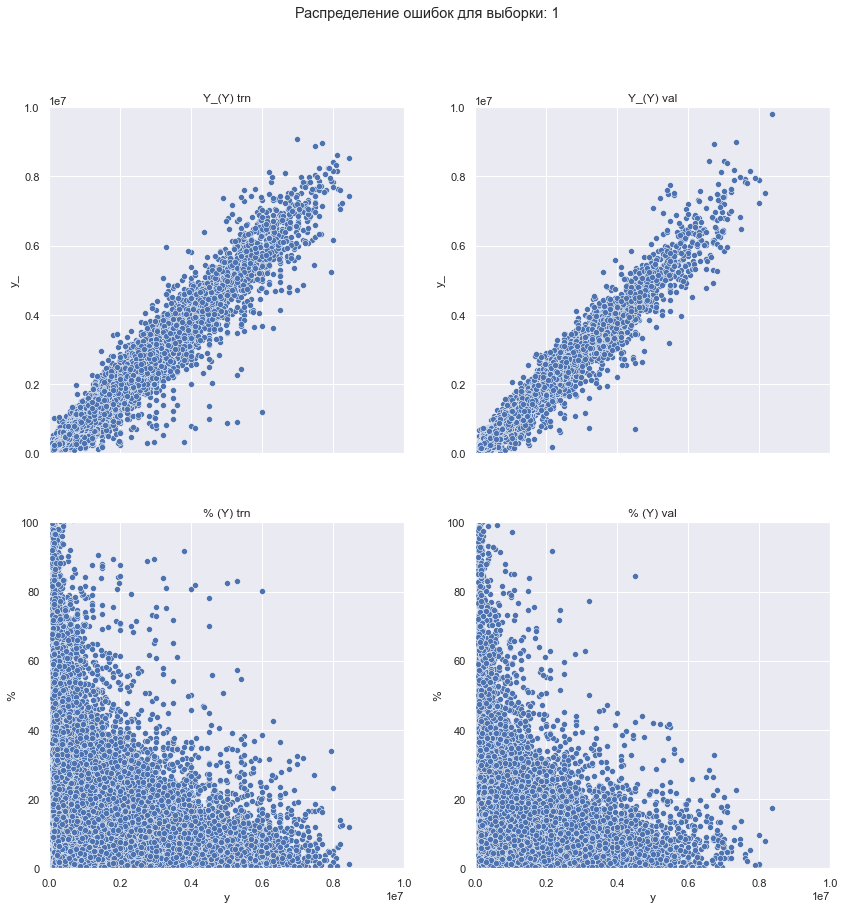

In [163]:
#Модель
model = LinearRegression(n_jobs=-1)
#Построение моделей
res_1, models_1 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***Получена метрика mape=12.4%. Распределение Y_(Y) получилось высокодисперсионным. Применим другие методы ML для улучшения mape.***

## 6.3) RandomForest (без bootstrap и настроек)

Построение модели для выборки 1/1.
   i  mape_trn  mape_val
0  1  0.000987  11.92773


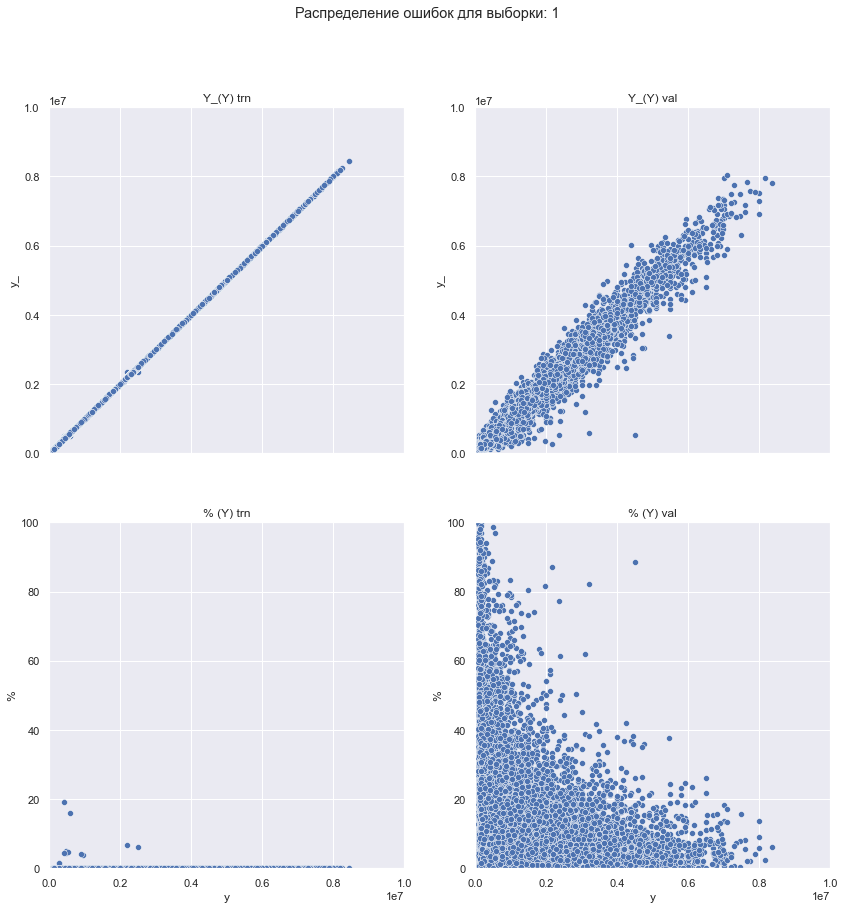

In [164]:
#Модель
model = RandomForestRegressor(n_jobs=-1,n_estimators=200,max_features=0.33,
                              random_state=random_state,bootstrap=False,max_samples=None)
#Построение моделей
res_2, models_2 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***На обучающей выборке получены идеальные результаты, при этом на валидационной mape достигает 11.9%. Это можно объяснить переобучением. Необходимо подобрать гиперпараметры модели и применить K-Fold кросс-валидацию.***

<span style='color:Red'> ***На данном моменте стоит отметить, что также было протестировано одинокое дерево решений и метод SVR. Все они дают результат примерно равный модели линейно регрессии.***</span>

## 6.4) RandomForest

<span style='color:Red'> ***Ниже приведен кусочек кода, по которому определялись гипер-параметры модели. Аналогичные кусочки кода были и для пунктов 6.5, 6.6, 6.7. Далее они удалены, чтобы место не занимать.***</span>

In [165]:
#   #Модель
#   model = RandomForestRegressor(n_jobs=-1,random_state=random_state)
#   param = [
#       {
#           'n_estimators': [200,300,400],
#           'max_depth': [None],
#           'min_samples_split': [8,10,12,15,17],
#           'min_samples_leaf': [1,3,5,7,10],
#           'max_features': [0.33,0.5,0.66],
#           'bootstrap': [True],
#           'max_samples': [0.6,0.8,None]
#       }
#   ]
#   reg_CV = GridSearchCV(model, param, n_jobs=-1, verbose=1, cv=5)
#   #Построение моделей
#   res_3, models_3 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], reg_CV)

Построение модели для выборки 1/1.
   i  mape_trn   mape_val
0  1  5.140369  11.535097


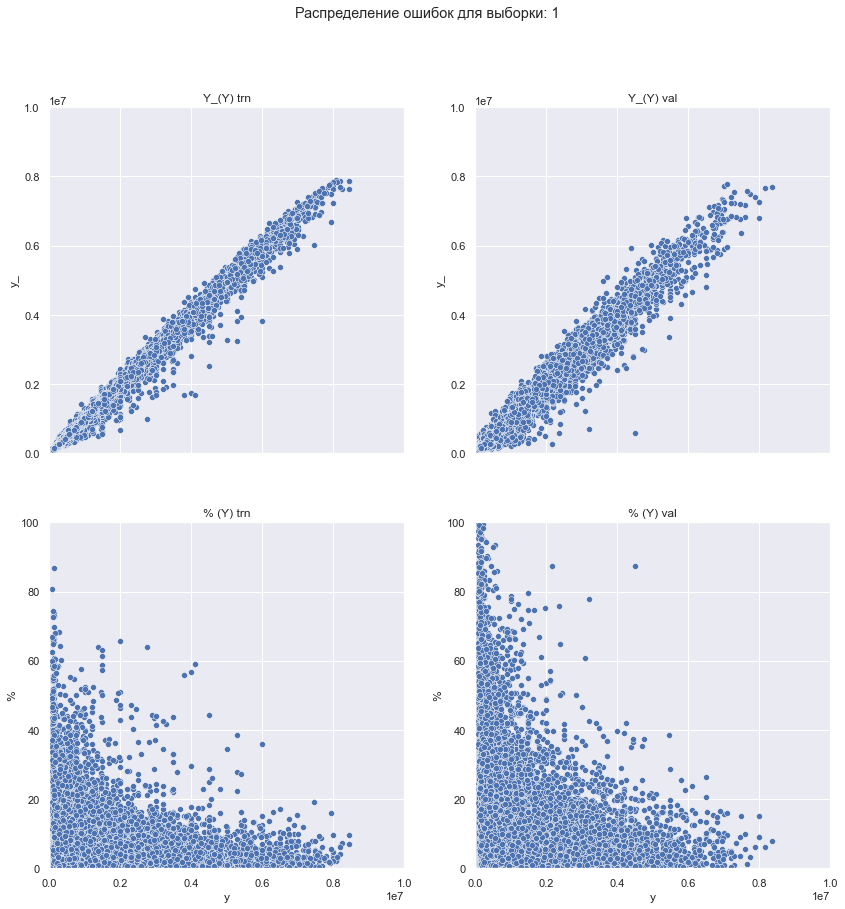

In [166]:
#Модель
model = RandomForestRegressor(n_jobs=-1,random_state=random_state,
                              n_estimators=200,max_depth=None,
                              min_samples_split=2,min_samples_leaf=1,
                              max_features=0.33,
                              bootstrap=True,max_samples=0.8)
#Построение моделей
res_3, models_3 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***Степень переобучения снизилась, немного упала mape=11.5.***

## 6.5) ExtraTrees

Построение модели для выборки 1/1.
   i  mape_trn   mape_val
0  1  8.847407  11.445452


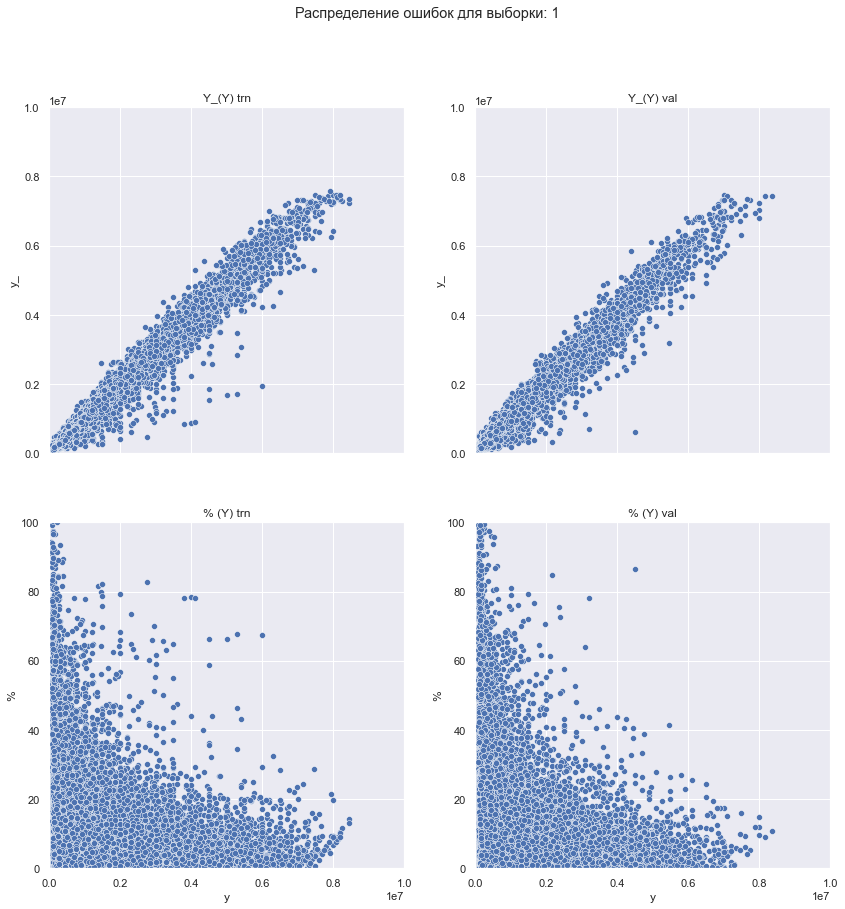

In [167]:
#Модель
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_state,
                            n_estimators=200,max_depth=None,
                            min_samples_split=14,min_samples_leaf=1,
                            max_features=0.75,
                            bootstrap=True,max_samples=0.75)
#Построение моделей
res_4, models_4 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***Степень переобучения значительно снизилась, немного упала mape=11.4. Похожий результат с random forest. Для обоих методов может быть повышена метрика с применением бэгинга.***

## 6.6) GradientBoosting

Построение модели для выборки 1/1.
   i  mape_trn   mape_val
0  1  8.394964  11.729861


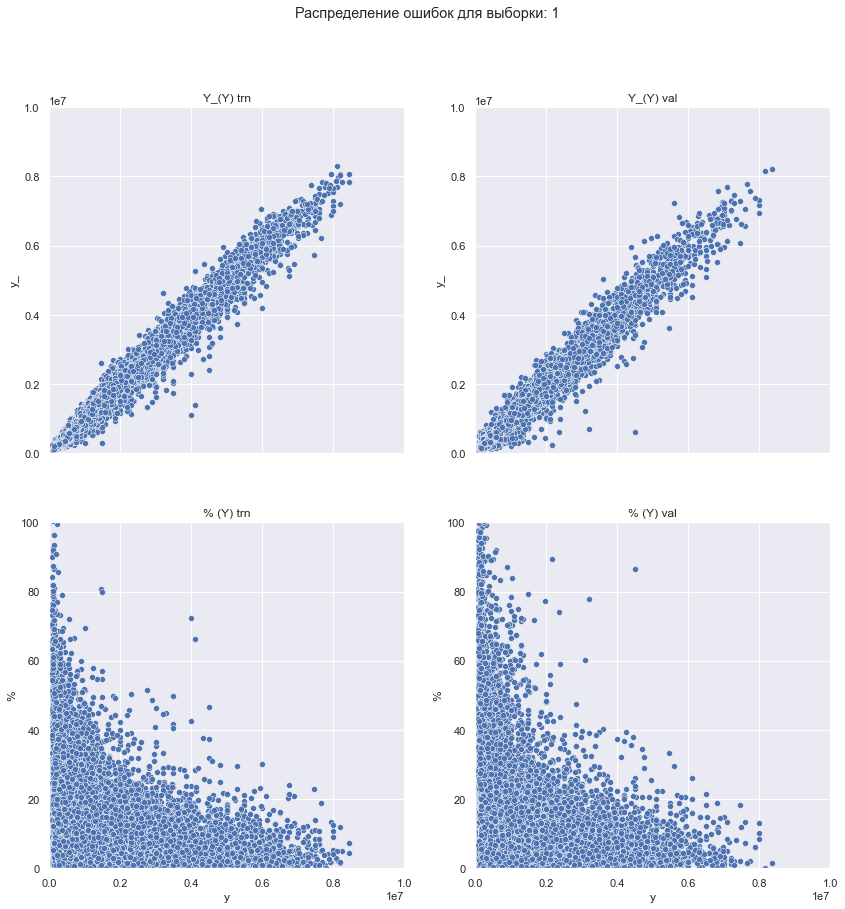

In [168]:
#Модель
model = GradientBoostingRegressor(random_state=random_state,learning_rate=0.3,
                                  n_estimators=100,max_depth=10,
                                  min_samples_split=2,min_samples_leaf=17,
                                  max_features=0.5)
#Построение моделей
res_5, models_5 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***Аналогично ExtraTrees. Степень переобучения значительно снизилась, немного упала mape=11.7. Может быть повышена метрика с применением бэгинга.***

## 6.7) CatBoosting

Построение модели для выборки 1/1.
   i  mape_trn   mape_val
0  1  7.189485  11.405455


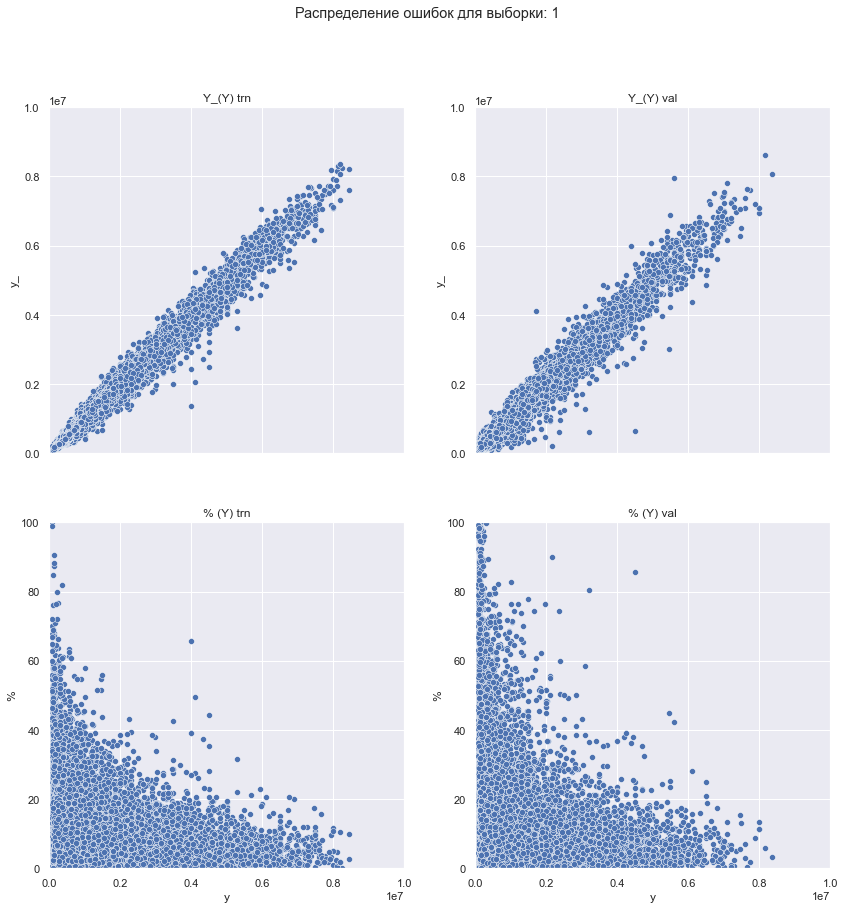

In [169]:
#Модель
model = CatBoostRegressor(iterations = 2500,
                          random_seed = random_state, silent=True,
                          eval_metric='MAPE',
                          learning_rate=0.1, depth=10,
                          l2_leaf_reg=13, random_strength=0.4)

#Построение моделей
res_6, models_6 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***Степень переобучения низкая - результат на валидационной выборке стал не сильно хуже. Метрика mape=11.4 лучше всех остальных, полученных ранее. Может быть повышена метрика с применением бэгинга.***

## 6.8) Baging (GradientBoosting)

Построение модели для выборки 1/1.
   i  mape_trn   mape_val
0  1  8.689705  11.255854


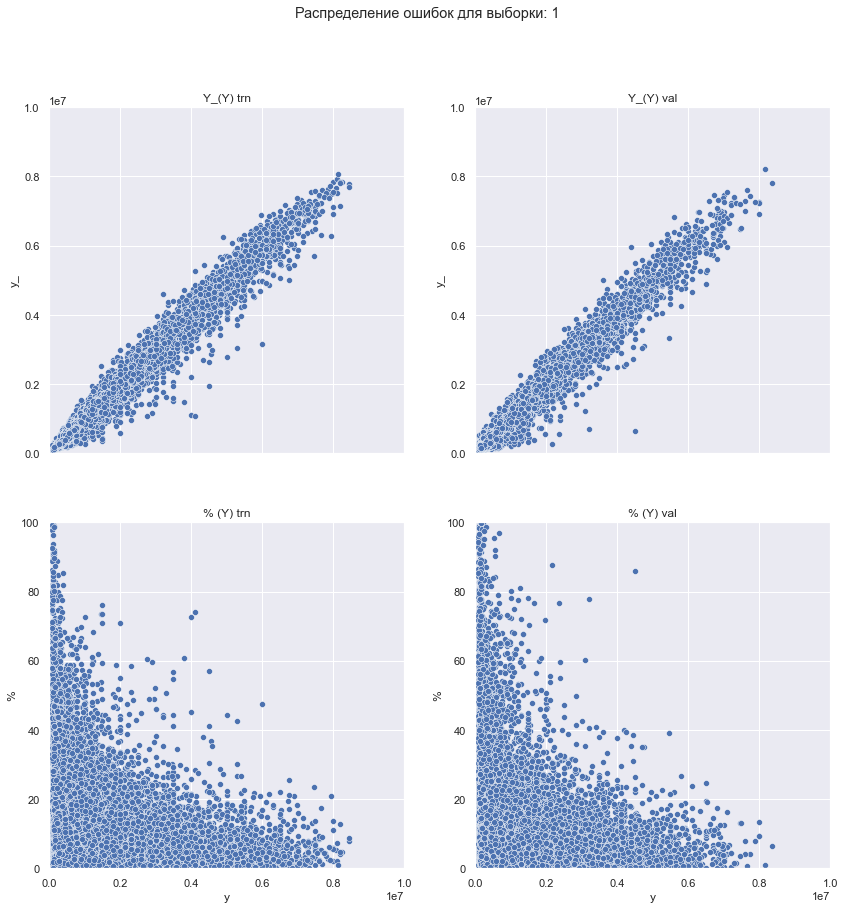

In [170]:
#Модель
model = BaggingRegressor(models_5[0], n_estimators=20, random_state=random_state, n_jobs=-1)
#Построение моделей
res_7, models_7 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], model)

***При применение бэгинга к модели градиентного бустинга была улучшена метрика mape до 11.2***.

***К сожалению при применении бэгинга к RandomForest, ExtraTrees, CatBoost желаемый результат не был улучшен, а то и на 0.2-0.5% ухудшен.***

## 6.9) Stacking

Построение модели для выборки 1/1.
   i  mape_trn   mape_val
0  1  7.718137  11.212279


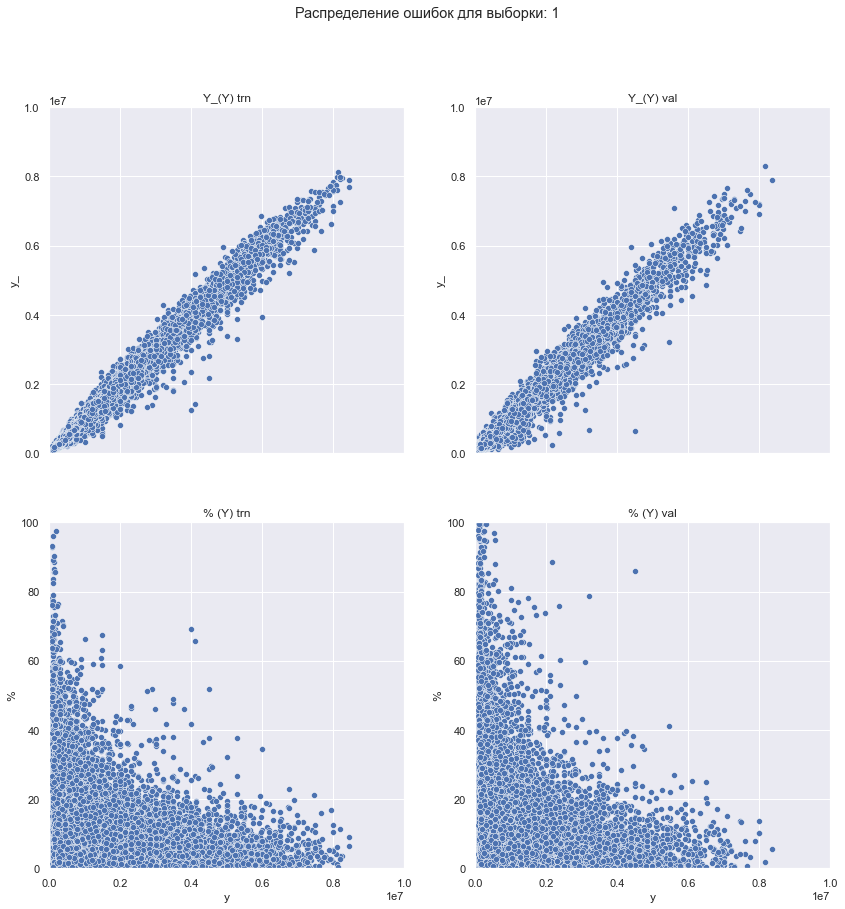

In [171]:
#Модель
estimators = [('RandomForest',   RandomForestRegressor(n_jobs=-1,random_state=random_state,
                                 n_estimators=200,max_depth=None,
                                 min_samples_split=2,min_samples_leaf=1,
                                 max_features=0.33,
                                 bootstrap=True,max_samples=0.8)),
              ('CatBoost',       CatBoostRegressor(iterations = 2500,
                                 random_seed = random_state, silent=True,
                                 eval_metric='MAPE',
                                 learning_rate=0.1, depth=10,
                                 l2_leaf_reg=13, random_strength=0.4)),
              ('BaggingBoosting',BaggingRegressor(models_5[0], n_estimators=20,
                                 random_state=random_state, n_jobs=-1))              
]
#Построение моделей
meta_model = StackingRegressor(estimators=estimators,
                               final_estimator=LinearRegression(n_jobs=-1),
                               n_jobs=-1,cv=5)
#Построение моделей
res_8, models_8 = ml.get_MLRegr([[X_trn,X_val,Y_trn,Y_val]], meta_model)

***Применение стэкинга позволило совсем незначительно улучшить метрику качества mape на 0.02% до 11.2%. В итоге это дало самый лучший результат.***

<span style='color:Red'> ***На Kaggle лучшие результаты соответствуют моделям CatBoost и Baging+GradientBoosting, а Stacking дает на 0.1-0.2% хуже. Возможно неверно подобран мета-алгоритм.***</span>

# 7. Kaggle

***На основе главы 7 обучим лучшие модели с оптимизированными гиперпараметрами на всей выборке (см.пункт 6.1). Для каждой из представленных ниже моделей за исключением градиентного бустинга результаты высылаются на Kaggle. Модели в данной главе обучаются на всей тестовой выборке.***

## 7.1) ML

***CatBoost.***

Построение модели для выборки 1/1.
   i  mape_trn  mape_val
0  1  7.844388  7.844388


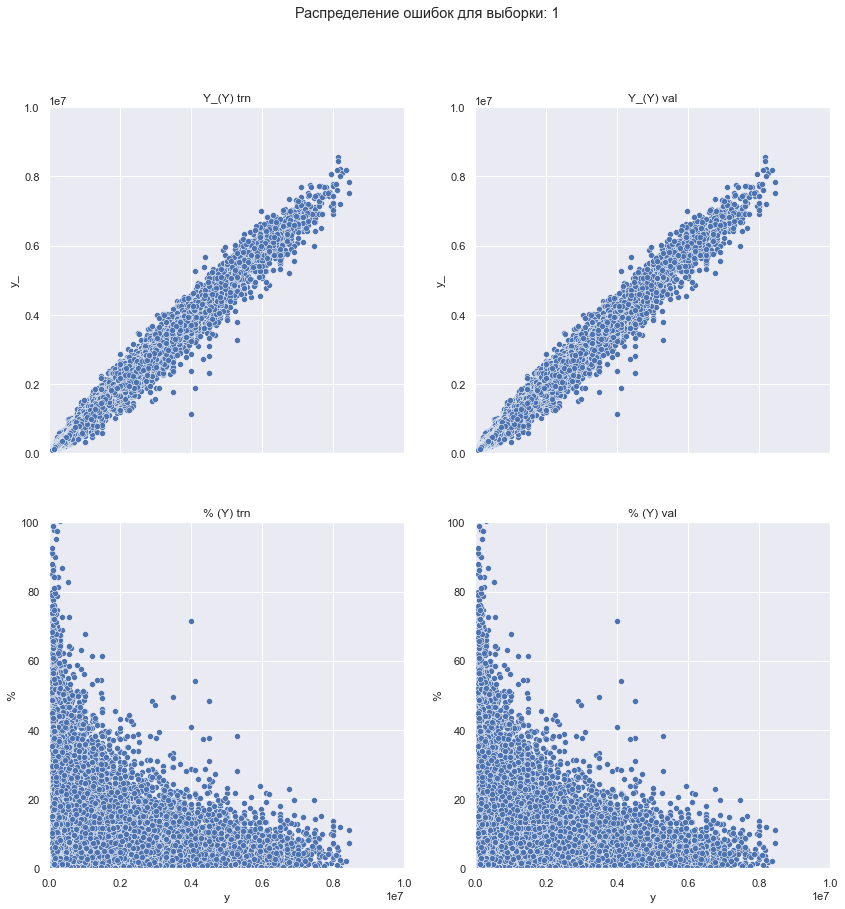

In [172]:
#Модель
model = CatBoostRegressor(iterations = 2500,
                          random_seed = random_state, silent=True,
                          eval_metric='MAPE',
                          learning_rate=0.1, depth=10,
                          l2_leaf_reg=13, random_strength=0.4)
#Построение моделей
K_res_1, K_models_1 = ml.get_MLRegr([[K_X_trn,K_X_val,K_Y_trn,K_Y_val]], model)

***Градиентный бустинг.***

Построение модели для выборки 1/1.
   i  mape_trn  mape_val
0  1  8.736915  8.736915


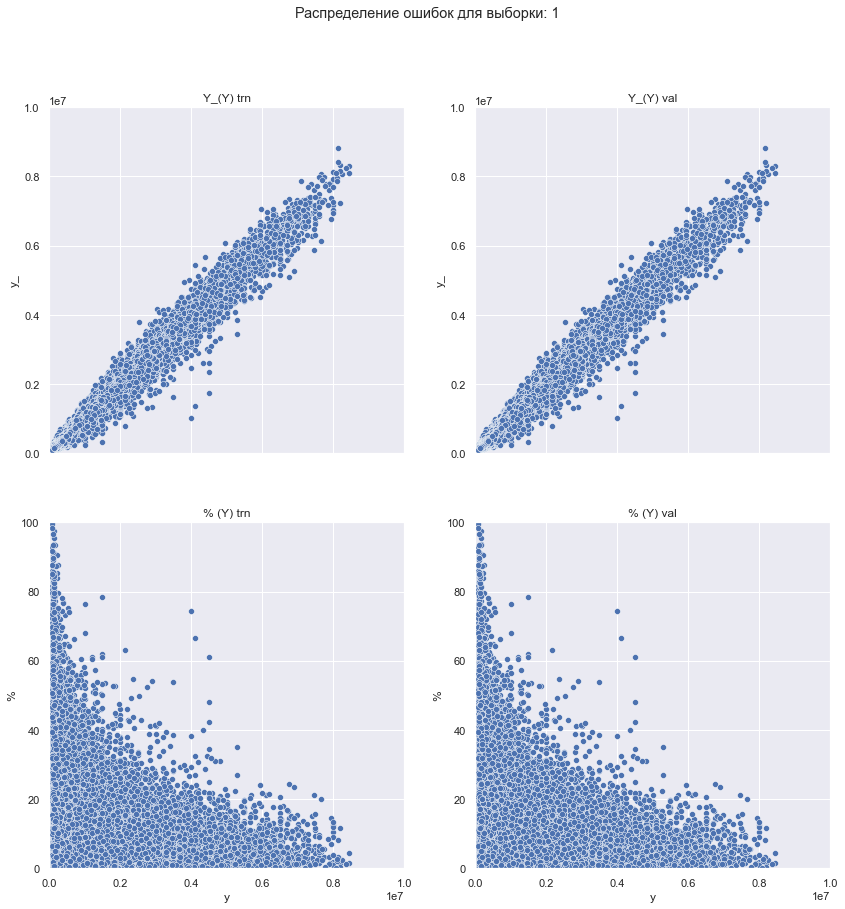

In [173]:
#Модель
model = GradientBoostingRegressor(random_state=random_state,learning_rate=0.3,
                                  n_estimators=100,max_depth=10,
                                  min_samples_split=2,min_samples_leaf=17,
                                  max_features=0.5)
#Построение моделей
K_res_2, K_models_2 = ml.get_MLRegr([[K_X_trn,K_X_val,K_Y_trn,K_Y_val]], model)

***Бэгинг градиентного бустинга.***

Построение модели для выборки 1/1.
   i  mape_trn  mape_val
0  1  8.995152  8.995152


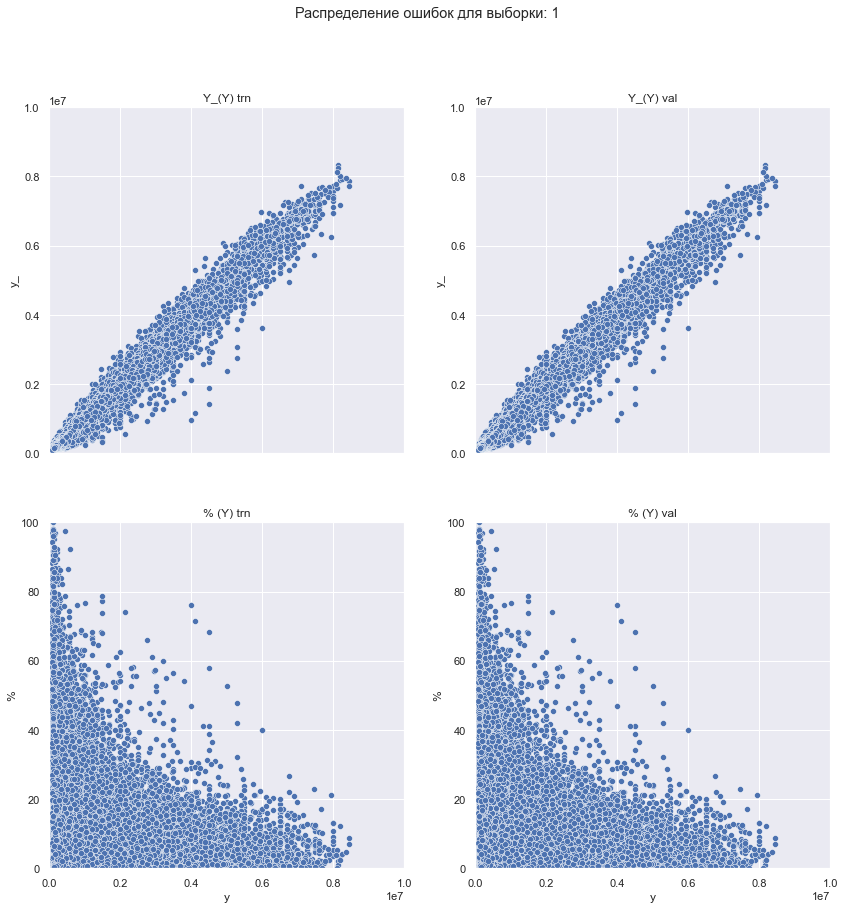

In [174]:
#Модель
model = BaggingRegressor(K_models_2[0], n_estimators=20, random_state=random_state, n_jobs=-1)
#Построение моделей
K_res_3, K_models_3 = ml.get_MLRegr([[K_X_trn,K_X_val,K_Y_trn,K_Y_val]], model)

***Stacking.***

Построение модели для выборки 1/1.
   i  mape_trn  mape_val
0  1  8.101327  8.101327


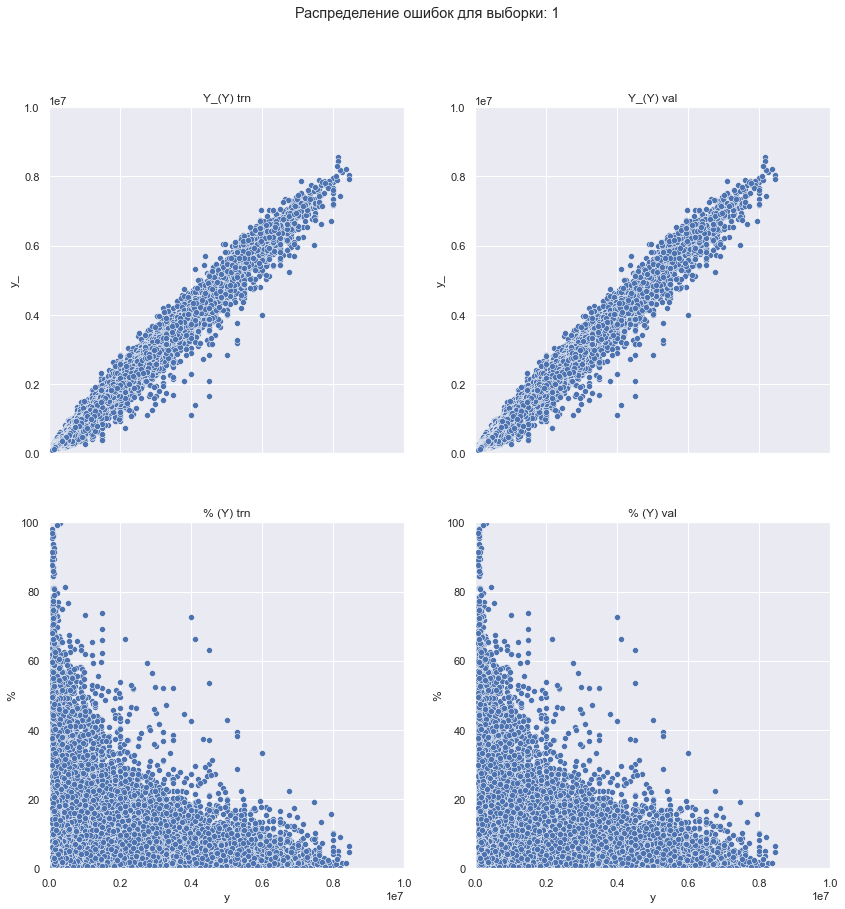

In [175]:
#Модель
estimators = [('RandomForest',   RandomForestRegressor(n_jobs=-1,random_state=random_state,
                                 n_estimators=200,max_depth=None,
                                 min_samples_split=2,min_samples_leaf=1,
                                 max_features=0.33,
                                 bootstrap=True,max_samples=0.8)),
              ('CatBoost',       CatBoostRegressor(iterations = 2500,
                                 random_seed = random_state, silent=True,
                                 eval_metric='MAPE',
                                 learning_rate=0.1, depth=10,
                                 l2_leaf_reg=13, random_strength=0.4)),
              ('BaggingBoosting',BaggingRegressor(K_models_2[0], n_estimators=20,
                                 random_state=random_state, n_jobs=-1))              
]
#Построение моделей
K_meta_model = StackingRegressor(estimators=estimators,
                               final_estimator=LinearRegression(n_jobs=-1),
                               n_jobs=-1,cv=5)
#Построение моделей
K_res_4, K_models_4 = ml.get_MLRegr([[K_X_trn,K_X_val,K_Y_trn,K_Y_val]], meta_model)

## 7.2) submit

<span style='color:Red'> ***Для лучшего результата на Kaggle.***</span>

In [176]:
#Выбираем лучшую модель
best_model = K_models_3[0]
#Предсказание на test
Y_pred_test = best_model.predict(K_X_tst)
#Пост-обработка
Y_pred_test = np.array([x if x > 9.8 else 9.8 for x in Y_pred_test])
Y_pred_test = np.array([x if x < 17.5 else 17.5 for x in Y_pred_test])
#Пост-обработка - удаление логорифмирования целевого признака
Y_pred_test = np.exp(Y_pred_test)

In [177]:
#Устранение ошибки
sample_submissions['price'] = Y_pred_test
df1 = sample_submissions.iloc[:,:2]
df2 = sample_submissions.iloc[:,2:]
df2 = df2.set_index('url')
k = 0.9 #Коэффициент, учитывающий кризис, инфляцию и рост цен
df1['price'] = df1['car_url'].apply(lambda x: df2.loc[x,'price']) * k
sample_submission = df1[['sell_id','price']]
#Вывод в файл
sample_submission.to_csv('submission.csv', index=False)
#Осмотр данных
sample_submission.head()

sell_id          price
0  1100575026  671828.538153
1  1100549428  962155.253415
2  1100658222  875621.858374
3  1100937408  704288.722232
4  1101037972  729003.404515

## 7.3) Выводы

***Была проведена работа по парсингу данных, последующей пост-обработке, feature engineering, EDA, обучения моделей ML и их ансамблей. По результатам работы была сформирована МОДЕЛЬ и был достигнут результат в соревновании на Kaggle: 13.84238.***

<span style='color:Red'> ***Было потречено ~40 попыток (остальные - это "авось лучше станет" и трата попыток на составление таблиц для результатов (которая получилась с 3 раза из-за невнимательности)).***</span>

***Лучший результат на Kaggle: 13.84238 (30/108 место на 23.04.2021). Для выборки без удаления выбросов.***

***Лучший результат на Kaggle: 15.36469 (48/108 место на 23.04.2021). Для выборки с удаления выбросов.***

In [178]:
#Таблица сравнений результатов - значения в таблице: метрика mape на Kaggle, %
m = np.array([[15.62960,15.43439,15.42165],[15.54947,15.36469,15.40350]])
pd.DataFrame(m.T,columns=['K=0.8','K=1.0'],index=['CatBoost','Baging+GradientBoosting','Stacking'])

K=0.8     K=1.0
CatBoost                 15.62960  15.54947
Baging+GradientBoosting  15.43439  15.36469
Stacking                 15.42165  15.40350

***Рост метрики на K=1.0 (где K - это отношение используемых прецендентов на финальной модели к полному количеству прецендентов), можно объяснить банально тем, что количество данных выше и модель на них лучше обучается.***

<span style='color:Red'> ***А вот с ростом метрики на Kaggle при отсутствии удалении выбросов ситуация весьма неоднозначная. С одной стороны выбросы нужно обязательно обрабатывать, так как они мешают обучению моделей. Но с другой стороны, как я описал в пункте 4.14, удаление именно этих прецендентов может привести к однозначно худшему результату на Kaggle, но к лучшем на валидационной выборке, так как модель старается предсказывать цены именно за период, собранный для обучающей выборки (2021 год).***</span>

## ***Как можно было бы еще улучшить работу:***

***1.Использовать LightAutoML, LightGBM и XGBoost.***

***2. Использовать для feature engineering описание объявлений и список технических особенностей (equipments).***

***3. Использовать дату производства модели, точное количество владельцев и технические особенности модели.***

***4. Подольше поработать с Stacking. Очень странно, что применение Stacking'а дает не существенный прирост метрики качества, а то и вовсем немного забирает.***

***5. Поэкспериментировать с набором данных - попробовать напарсить данные для других брендов или вообще с других сайтов.***

***6. Поработать с выбросами.***

## Ссылка на Git: https://github.com/MirtosSergey/SF_project/tree/master
## Ник на Kaggle: MirtosSergey